# Step 1

* Load scalar, waveform and image h5 files.
* Snap the points onto a regular grid in x1-x2 space.
* Interpolate the points onto a regular y1 grid.
* Generate the file "rawgrid_....mmp" containing the 5D density array in slit-screen (x1-x2-y1-y3-x3) coordinates.
* Generate the file "rawgrid_coordinates_....npy" containing the mesh coordinates for "rawgrid_....mmp".

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from plotly import graph_objects as go
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Setup 

Global variables

In [3]:
SMOOTH = False  # whether to smooth y1-y3-x3 image along first axis

Load info from step 0.

In [4]:
folder = '_output'

In [5]:
info = utils.load_pickle(join(folder, 'info.pkl'))
info

{'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'datadir': '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29',
 'filename': '220429190854-scan-xxpy-image-ypdE',
 'variables': {'y1': {'pvname': 'ITSF_Diag:Slit_HZ34a',
   'center': 6.5,
   'distance': 14.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x2': {'pvname': 'ITSF_Diag:Slit_VT34b',
   'center': 15.0,
   'distance': 24.0,
   'steps': 32,
   'min': -50.0,
   'max': 50.0},
  'x1': {'pvname': 'ITSF_Diag:Slit_VT34a',
   'center': 21.0,
   'distance': 17.5,
   'steps': 32,
   'min': -50.0,
   'max': 50.0}},
 'M': array([[1. , 0. , 0. ],
        [0. , 1. , 1.9],
        [0. , 0. , 1. ]]),
 'ndim': 3,
 'cam': 'cam34',
 'cam_zoom': 0.5,
 'cam_pix2mm_y': 0.4,
 'cam_pix2mm_x': 0.3968253968253968,
 'cam_shape': (512, 612),
 'image_crop_edges': {'x1': 200, 'x2': 450, 'y1': 135, 'y2': 435},
 'image_offset': 28.0,
 'image_thresh': 98.0,
 'image_downscale': 4,
 'image_shape': (75, 63)}

In [6]:
datadir = info['datadir']
filenames = os.listdir(datadir)
filenames

['220429190854-scan-xxpy-image-ypdE.png',
 '220429190854-scan-xxpy-image-ypdE.csv',
 '220429190854-scan-xxpy-image-ypdE.html',
 '220429190854-scan-xxpy-image-ypdE.txt',
 '220429190854-scan-xxpy-image-ypdE.h5',
 'preproc-220429190854-scan-xxpy-image-ypdE.h5',
 'images.h5']

In [7]:
filename = info['filename']
file = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'r')
data_sc = file['/scalardata']
data_wf = file['/wfdata']
data_im = file['/imagedata']

print('All attributes:')
print()
for data in [data_sc, data_wf, data_im]:
    print(data.name)
    for item in data.dtype.fields.items():
        print(item)
    print()

All attributes:

/scalardata
('x_PositionSync', (dtype('<f8'), 0))
('xp_PositionSync', (dtype('<f8'), 8))
('y_PositionSync', (dtype('<f8'), 16))
('bcm04', (dtype('<f8'), 24))
('cam34_Integral', (dtype('<f8'), 32))
('cam34_Saturation', (dtype('<f8'), 40))
('iteration', (dtype('int64'), 48))
('timestamp', (dtype('<f8'), 56))

/wfdata
('cam34_ProfileX', (dtype(('<f4', (612,))), 0))
('cam34_ProfileY', (dtype(('<f4', (512,))), 2448))

/imagedata
('cam34_Image', (dtype(('<f8', (4725,))), 0))



## Scan overview

### Measured camera integral 

In [8]:
cam = info['cam']
scalar_diag = ['bcm04', f'{cam}_Integral', f'{cam}_Saturation']
acts = info['acts']
print('Scalar diagnostics:', scalar_diag)
print('Actuators:', acts)

Scalar diagnostics: ['bcm04', 'cam34_Integral', 'cam34_Saturation']
Actuators: ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync']


Index of peak signal: 31474
Signal min = 0.10597099902119254


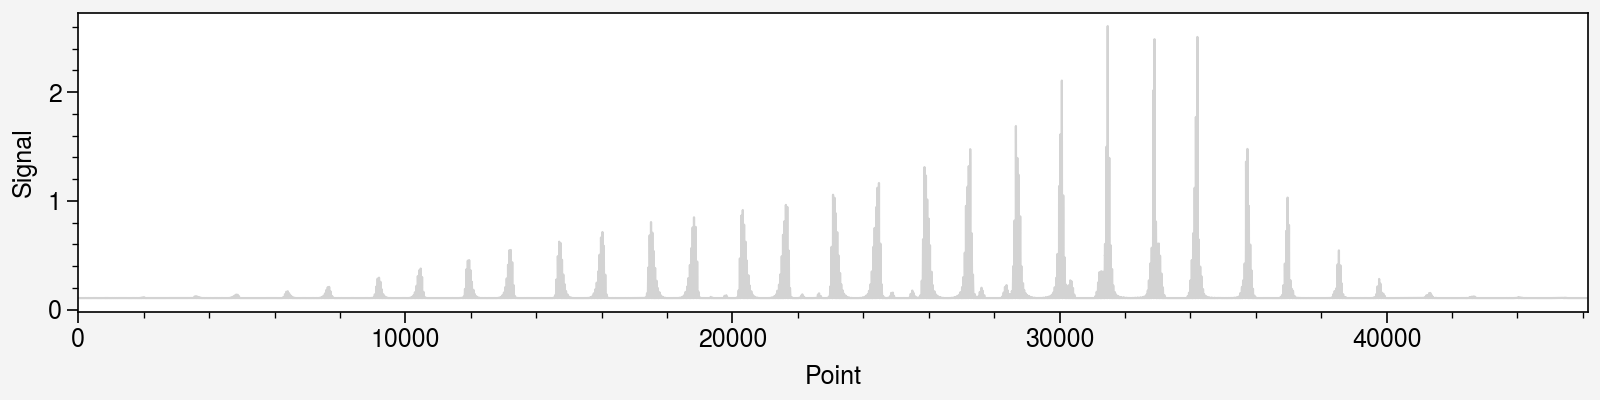

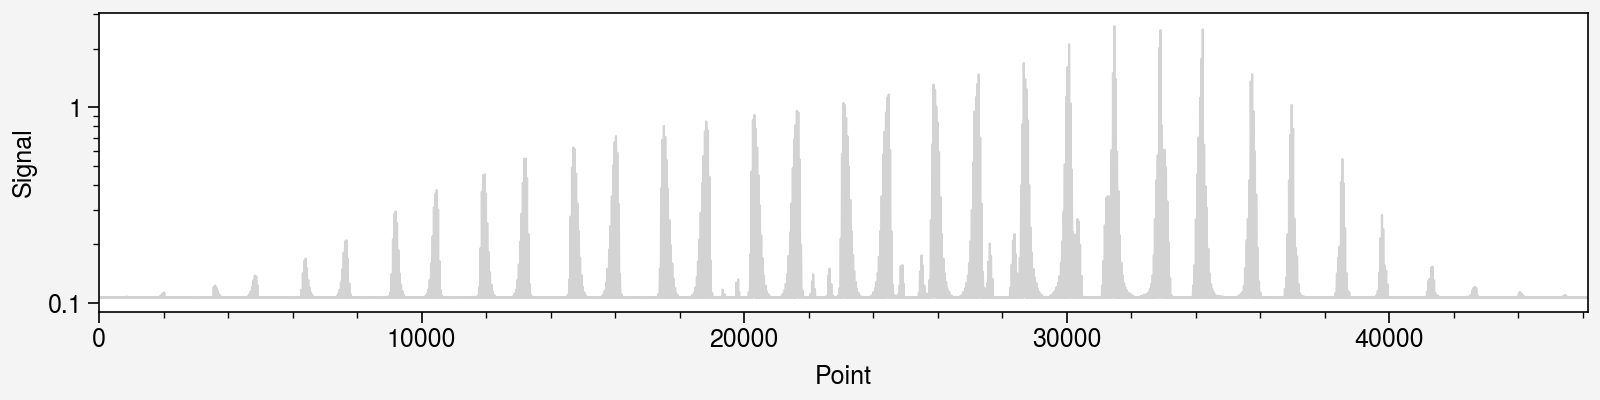

In [9]:
signal = np.copy(data_sc[:, cam + '_Integral'])
ipeak = np.argmax(signal)
print('Index of peak signal:', ipeak)
print(f'Signal min = {np.min(signal)}')

for yscale in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(8.0, 2.0))
    ax.plot(signal, lw=0.8, color='lightgrey')
    ax.format(yscale=yscale, ylabel='Signal', xlabel='Point')
    plt.savefig(f'_output/signal_raw_{yscale}.png')
    plt.show()

Subtract the offset from the signal and normalize to the range [0, 1]. Then apply a threshold. `valid` stores the indices of the points with `signal` > `thresh`.

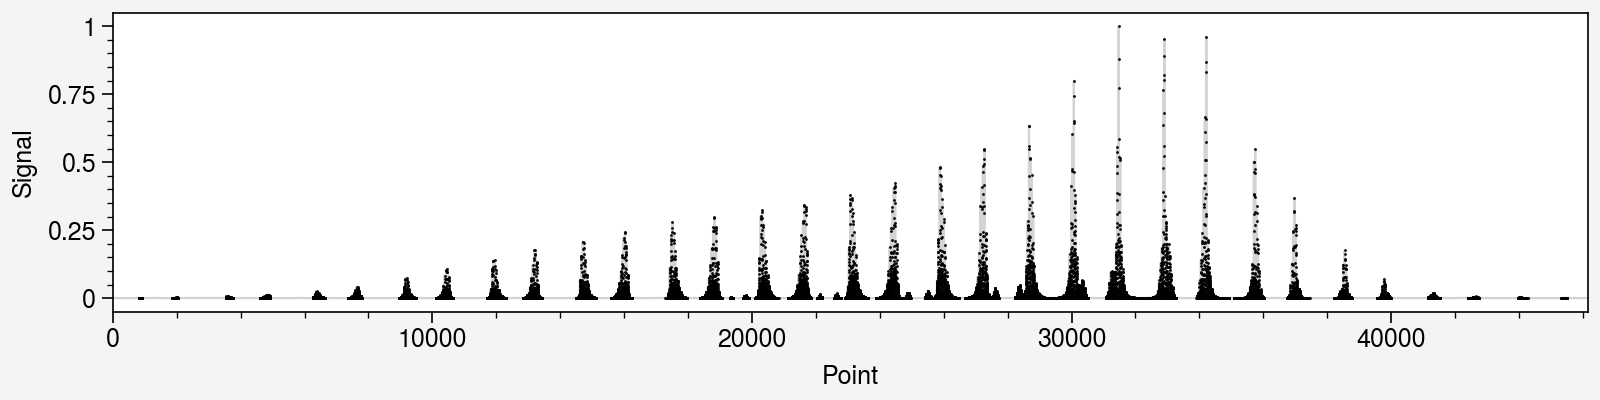

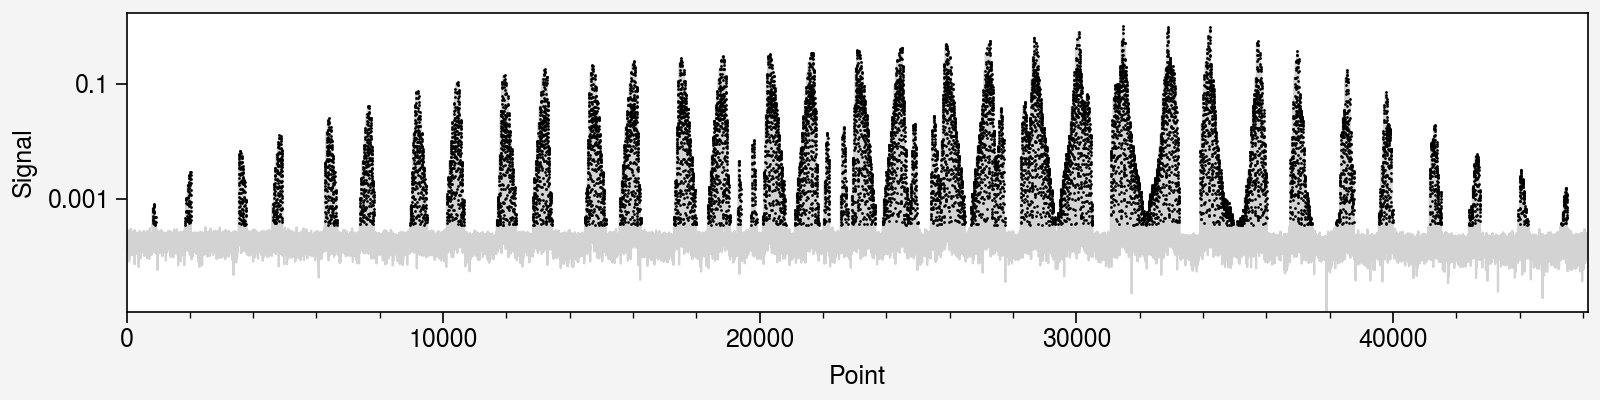

In [15]:
signal = signal - np.min(signal)
signal = signal / np.max(signal)
thresh = 0.00035  # fraction of max signal
valid, = np.where(signal >= thresh)

for yscale in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(8.0, 2.0))
    ax.plot(signal, color='lightgrey', lw=0.8)
    ax.plot(valid, signal[valid], lw=0, marker='.', ms=2, alpha=1, ec='None', color='black')
    ax.format(yscale=yscale, ylabel='Signal', xlabel='Point')
    plt.savefig(f'_output/signal_{yscale}.png')
    plt.show()

### Scan path

Work in the normalized (centered, decorrelated) slit-screen coordinates. 

In [16]:
variables = info['variables']
variables

{'y1': {'pvname': 'ITSF_Diag:Slit_HZ34a',
  'center': 6.5,
  'distance': 14.5,
  'steps': 32,
  'min': -50.0,
  'max': 50.0},
 'x2': {'pvname': 'ITSF_Diag:Slit_VT34b',
  'center': 15.0,
  'distance': 24.0,
  'steps': 32,
  'min': -50.0,
  'max': 50.0},
 'x1': {'pvname': 'ITSF_Diag:Slit_VT34a',
  'center': 21.0,
  'distance': 17.5,
  'steps': 32,
  'min': -50.0,
  'max': 50.0}}

In [17]:
keys = list(variables)
center = np.array([variables[key]['center'] for key in keys])
distance = np.array([variables[key]['distance'] for key in keys])
nsteps = np.array([variables[key]['steps'] for key in keys])
print(keys)

['y1', 'x2', 'x1']


In [18]:
ndim = info['ndim']
M = info['M']
Minv = np.linalg.inv(M)
print(M)

[[1.  0.  0. ]
 [0.  1.  1.9]
 [0.  0.  1. ]]


Extract the readback actuator points and normalize them.

In [19]:
points = np.vstack([data_sc[act] for act in acts]).T
points_n = utils.apply(Minv, points - center)
points_nn = points_n / (0.5 * distance)

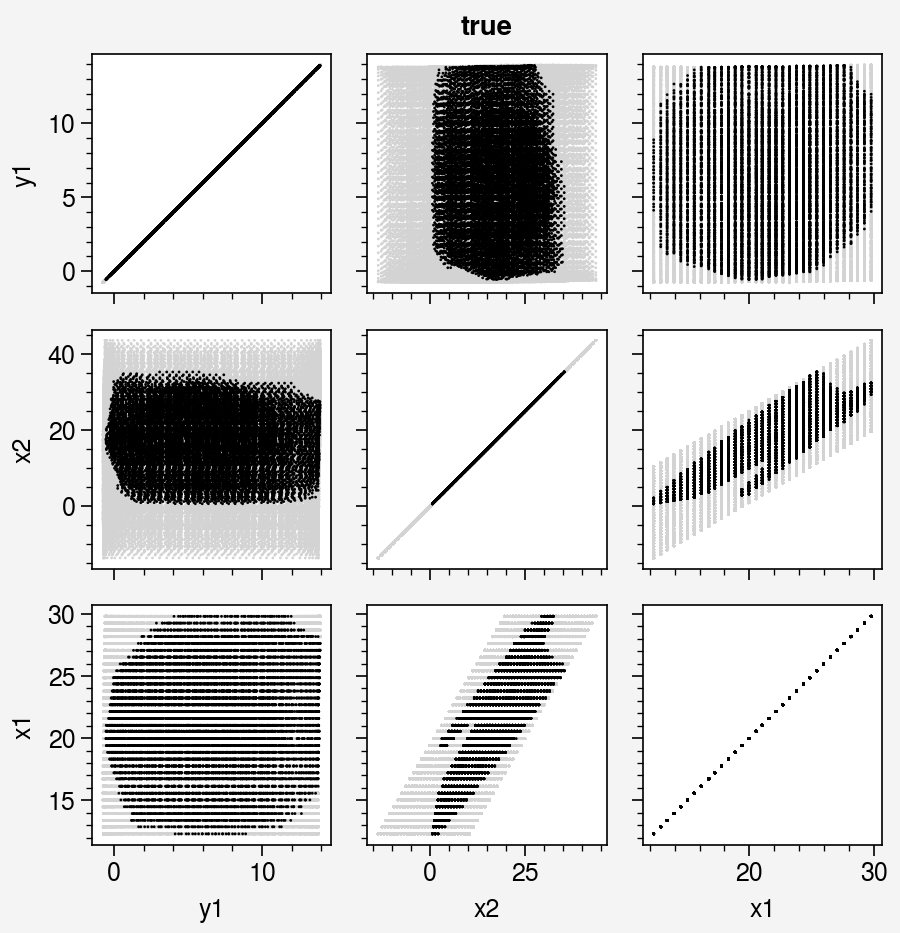

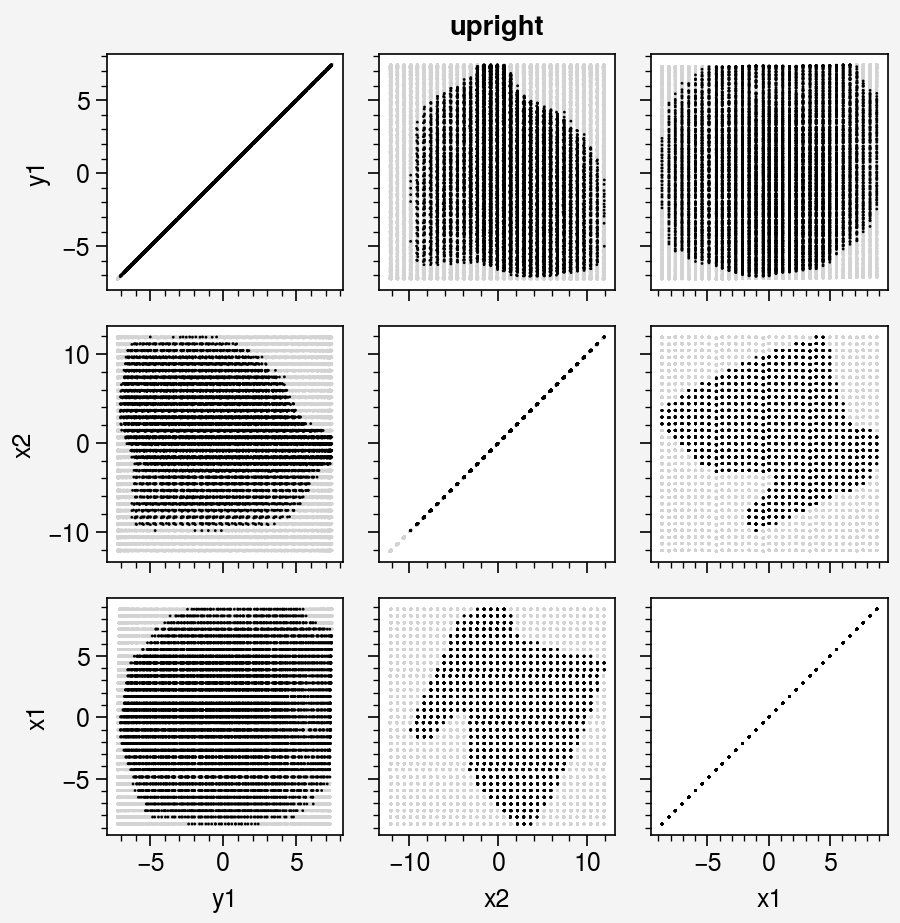

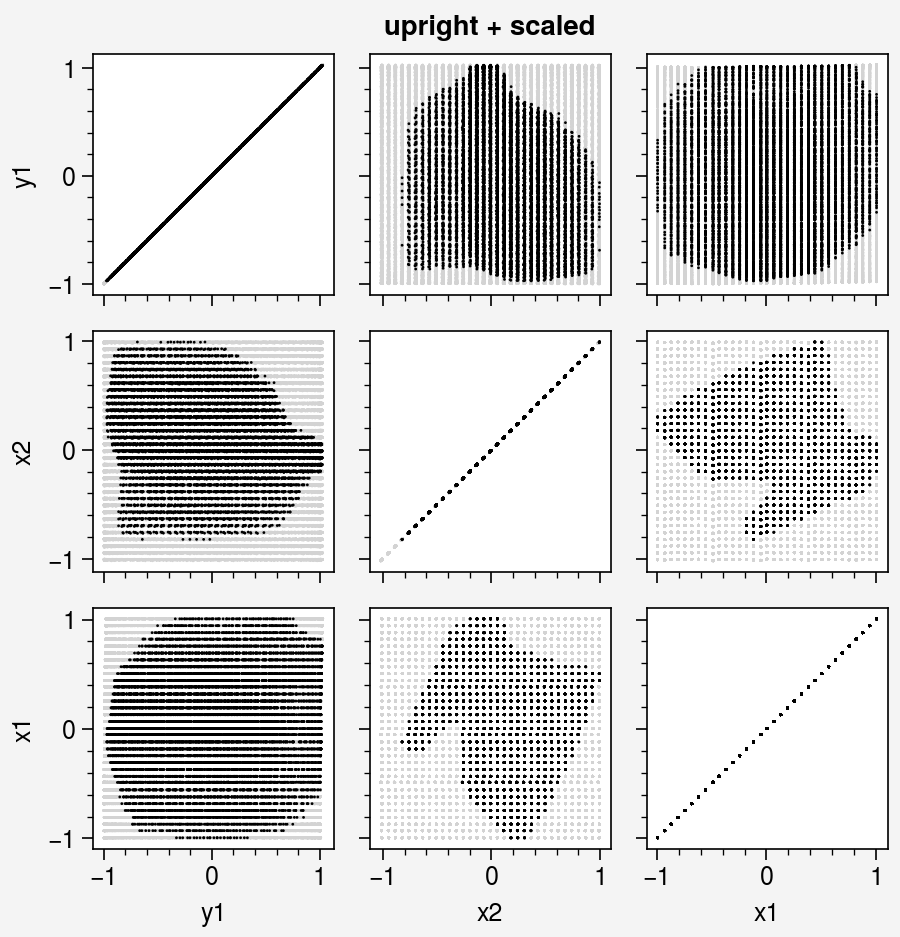

In [20]:
for _points, title in zip((points, points_n, points_nn), ('true', 'upright', 'upright + scaled')):
    fig, axes = pplt.subplots(ncols=3, nrows=3, figwidth=4.5, span=False)
    axes.format(suptitle=title)
    for i in range(3):
        for j in range(3):
            axes[i, j].scatter(_points[:, j], _points[:, i], c='lightgray', ec='None', s=1)
            axes[i, j].scatter(_points[valid, j], _points[valid, i], c='black', ec='None', s=1)
        axes[i, 0].format(ylabel=keys[i])
        axes[-1, i].format(xlabel=keys[i])
    plt.savefig(f'_output/points_{title}.png')
    plt.show()

3D interactive plot.

In [21]:
invalid, = np.where(signal < thresh)
x, y, z = points_nn[invalid, :].T.copy()
u, v, w = points_nn[valid, :].T.copy()
fig = go.Figure(
    data=[
        go.Scatter3d(x=x, y=y, z=z, mode='markers', 
                     marker=dict(color='lightgray', size=1, opacity=0.5)),
        go.Scatter3d(x=u, y=v, z=w, mode='markers', 
                     marker=dict(color='black', size=1, opacity=0.5)),
    ]
)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
fig.update_layout(width=500, height=500)
fig.write_html('_output/points3d.html')
# fig.show()

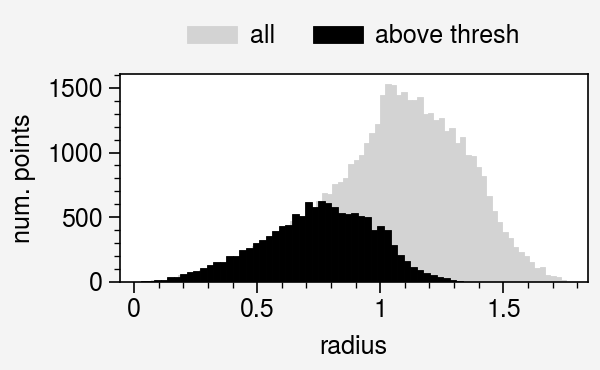

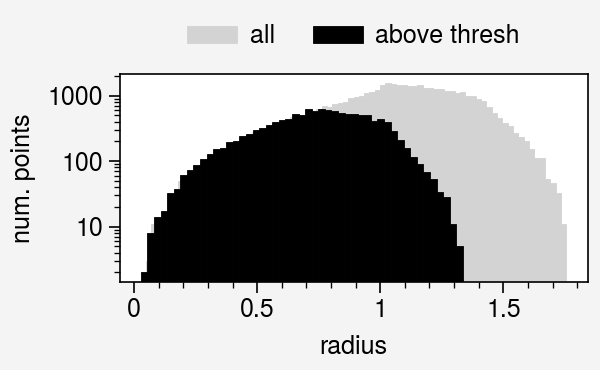

In [22]:
radii = np.sqrt(np.sum(np.square(points_nn), axis=1))

with pplt.rc.context(legendfontsize='medium'):
    for yscale in [None, 'log']:
        fig, ax = pplt.subplots(figsize=(3, 1.85))
        ax.hist(radii, bins='auto', label='all', color='lightgrey')
        ax.hist(radii[valid], bins='auto', label='above thresh', color='black')
        ax.format(ylabel='num. points', xlabel='radius', yscale=yscale)
        ax.legend(ncols=2, loc='top', framealpha=0)
        plt.savefig(f'_output/radial_dist_{yscale}.png')
        plt.show()

We can compare these with the planned points listed in the csv file.

In [23]:
csv_filename = join(datadir, filename + '.csv')
skiprows = 0
for line in open(csv_filename, 'r'):
    if line.startswith('#'):
        skiprows += 1
names = []
for i in range(1, 4):
    names.extend([f'start{i}', f'stop{i}', f'step{i}'])
df = pd.read_table(csv_filename, skiprows=skiprows, sep='\s+', header=None, names=names)
df

,start1,stop1,step1,start2,stop2,step2,start3,stop3,step3
0,-0.75,13.75,2.266,-13.625,-13.625,0.0,12.25,12.25,0.0
1,13.75,-0.75,2.266,-12.875,-12.875,0.0,12.25,12.25,0.0
2,-0.75,13.75,2.266,-12.125,-12.125,0.0,12.25,12.25,0.0
3,13.75,-0.75,2.266,-11.375,-11.375,0.0,12.25,12.25,0.0
4,-0.75,13.75,2.266,-10.625,-10.625,0.0,12.25,12.25,0.0
...,...,...,...,...,...,...,...,...,...
1084,-0.75,13.75,2.266,40.625,40.625,0.0,29.75,29.75,0.0
1085,13.75,-0.75,2.266,41.375,41.375,0.0,29.75,29.75,0.0
1086,-0.75,13.75,2.266,42.125,42.125,0.0,29.75,29.75,0.0
1087,13.75,-0.75,2.266,42.875,42.875,0.0,29.75,29.75,0.0


Make sure the actuator names in this notebook match the order in the CSV file.

In [24]:
header_line = None
for row, line in enumerate(open(join(datadir, filename + '.csv'), 'r')):
    if row == skiprows - 1:
        header_line = line
        break
for char in ['#', ',']:
    header_line = header_line.replace(char, '')
header_line = header_line.lstrip()
print(header_line.split())

['step', 'ITSF_Diag:Slit_HZ34a', 'start', 'stop', 'speed', 'ITSF_Diag:Slit_VT34b', 'start', 'stop', 'speed', 'ITSF_Diag:Slit_VT34a', 'start', 'stop', 'speed']


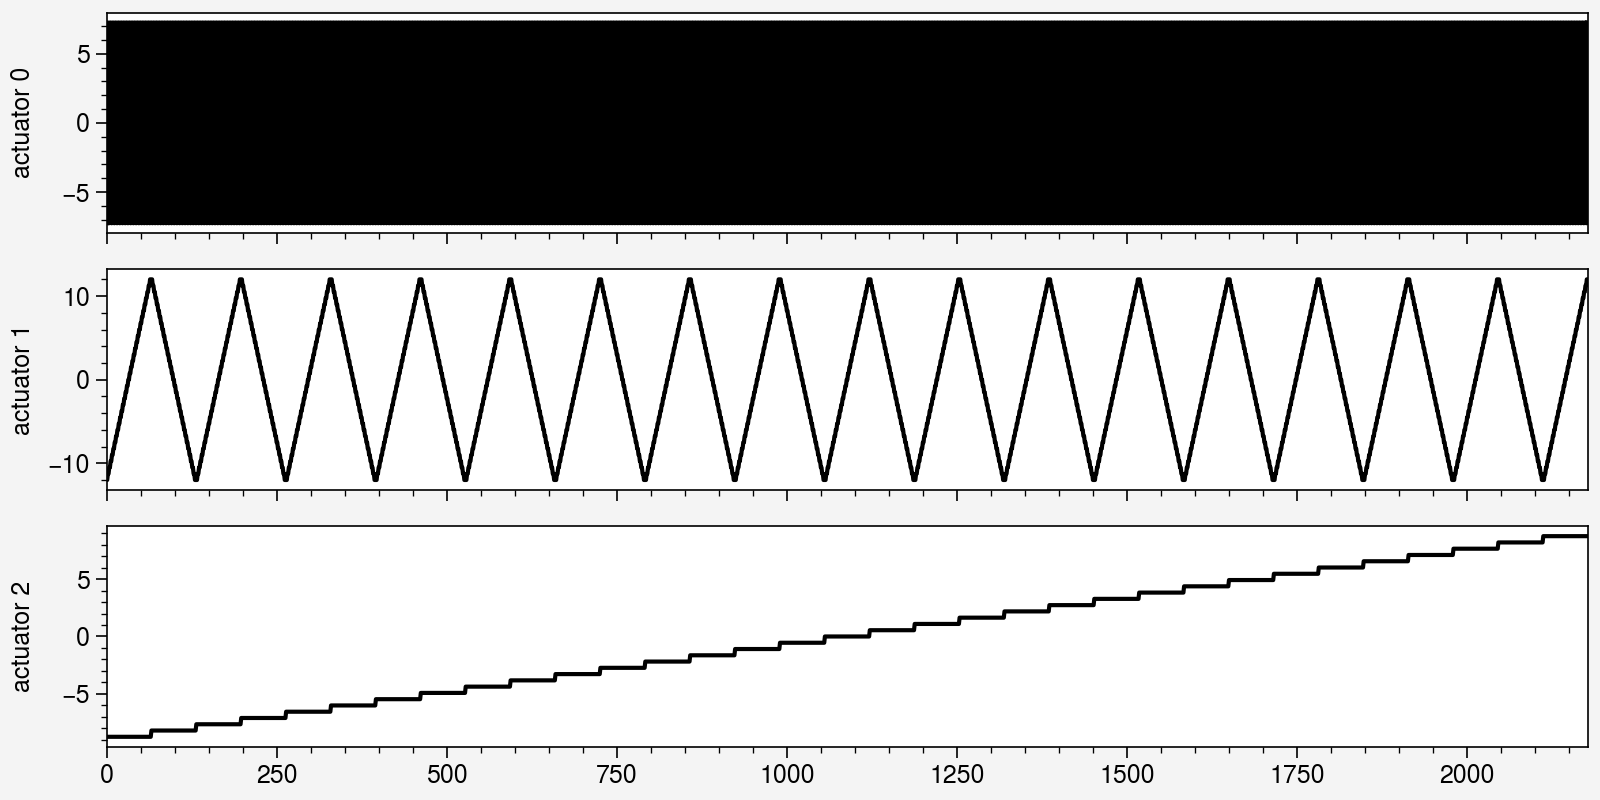

In [25]:
# Extract planned actuator points.
pl_points = [df.loc[:, [f'start{i}', f'stop{i}']].values.ravel() 
             for i in range(1, ndim + 1)]
pl_points = np.array(pl_points).T

# Undo linear transformation.
pl_points_n = utils.apply(Minv, pl_points - center)
pl_points_nn = pl_points_n / (0.5 * distance)

# Plot planned points in "normalized" space.
fig, axes = pplt.subplots(nrows=3, figsize=(8.0, 4.0), spany=False, aligny=True)
for i, ax in enumerate(axes):
    ax.plot(pl_points_n[:, i], color='black', lw=None, marker='.', ms=0)
    ax.format(ylabel=f'actuator {i}')
plt.savefig('_output/planned_acts_n.png')

Create dataframe of planned actuator points in real and normalized space.

In [26]:
dim_names = keys
columns = []
for i, dim_name in enumerate(dim_names):
    columns.extend([dim_name, dim_name + '_n', dim_name + '_nn'])
df = pd.DataFrame(index=df.index, columns=columns)
for i, dim_name in enumerate(dim_names):
    df[dim_name] = pl_points[::2, i]
    df[dim_name + '_n'] = pl_points_n[::2, i]
    df[dim_name + '_nn'] = pl_points_nn[::2, i]
df

,y1,y1_n,y1_nn,x2,x2_n,x2_nn,x1,x1_n,x1_nn
0,-0.75,-7.25,-1.0,-13.625,-12.00,-1.0000,12.25,-8.75,-1.0
1,13.75,7.25,1.0,-12.875,-11.25,-0.9375,12.25,-8.75,-1.0
2,-0.75,-7.25,-1.0,-12.125,-10.50,-0.8750,12.25,-8.75,-1.0
3,13.75,7.25,1.0,-11.375,-9.75,-0.8125,12.25,-8.75,-1.0
4,-0.75,-7.25,-1.0,-10.625,-9.00,-0.7500,12.25,-8.75,-1.0
...,...,...,...,...,...,...,...,...,...
1084,-0.75,-7.25,-1.0,40.625,9.00,0.7500,29.75,8.75,1.0
1085,13.75,7.25,1.0,41.375,9.75,0.8125,29.75,8.75,1.0
1086,-0.75,-7.25,-1.0,42.125,10.50,0.8750,29.75,8.75,1.0
1087,13.75,7.25,1.0,42.875,11.25,0.9375,29.75,8.75,1.0


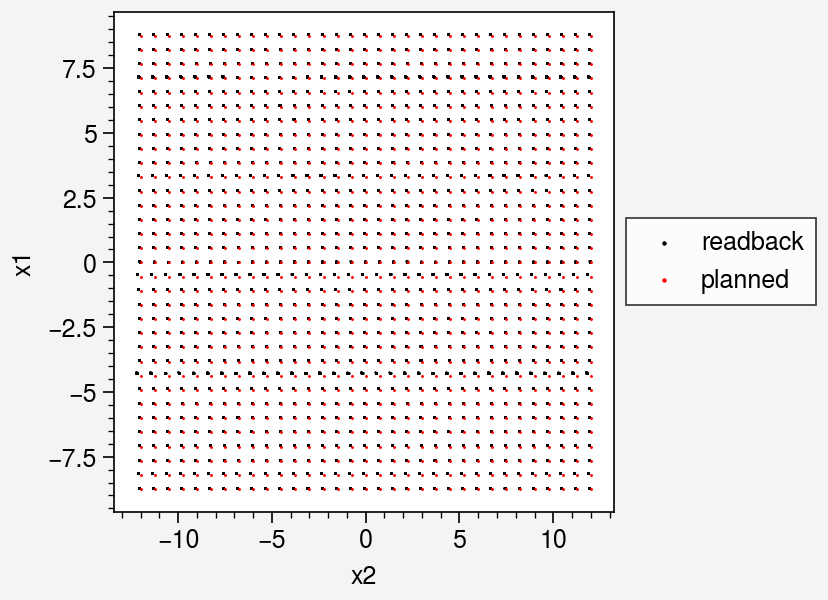

In [27]:
fig, ax = pplt.subplots()
ax.scatter(points_n[:, 1], points_n[:, 2], c='black', s=0.1, label='readback')
ax.scatter(pl_points_n[:, 1], pl_points_n[:, 2], c='red', s=0.1, label='planned')
ax.legend(loc='r', ncols=1, ms=1)
ax.format(xlabel='x2', ylabel='x1')
plt.savefig('_output/x2-x1_planned_readback.png')
plt.show()

## Interpolation 

### Snap points onto x1-x2 grid

We will use the planned points, which should be close to the real points in x1-x2. Need to play with `n` below until the expected number of grid points is obtained. We want the readback points to be relatively close to the grid points.

i = 1


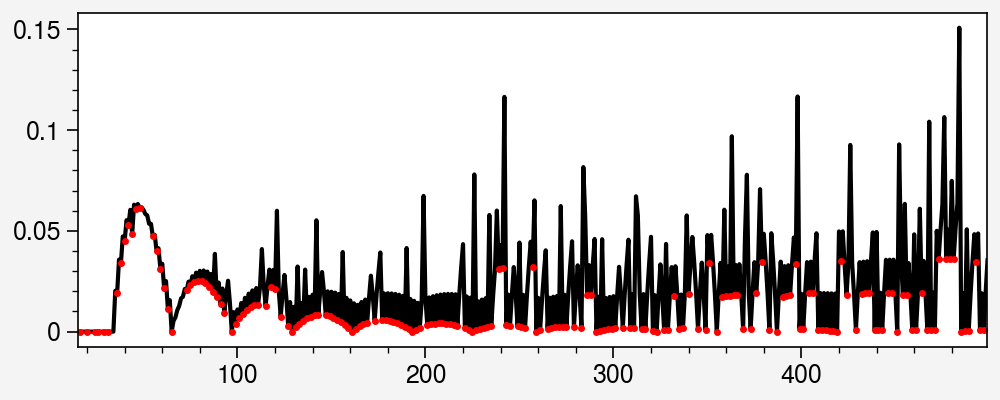

[ 20  26  31  16  24  29 291 419 355 323  97 387 259 193 451 485 225 161
  65 129 487 417 489 321 293 415 383 261 495 459 413 497 443 327 461 227
 471 441 469 411 467 429 295 223 439 349 409 329 195 399 401 317 191 297
 373 369 345 315 229 163 299 335 265 337 221 301 283 159 253 311 267 197
 309 305 231 269 131 279 251 271 189 273 233 275 249 165 235 127 217 245
 243 201 187 157 215  99 203 167 213 205 133 211 185 207 209 169 183 155
 181 135 173 179 177 153 101 137 151 139 123 149 141 147 143 103  93 105
  63 107 115 109 111  91  89 358 390 360 392 362 332 288 454 424 394 364
 286 456 366 340 432 376 404 434 464 406  36 436 448 446  87  73 120  61
 118  85  75  83  77  81  79  59 239 241 257 397  38 351 493 379 421 473
 477 479 481  57  40  55  44  42  46  48]

i = 2


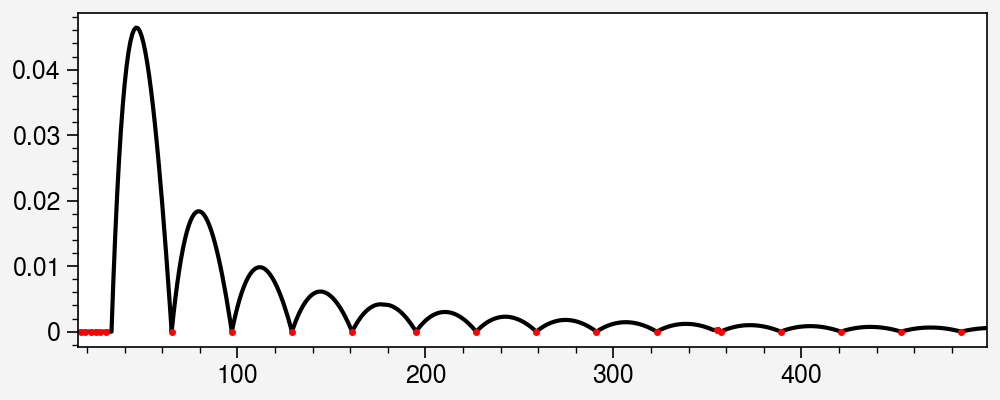

[ 17  22  30  97  25 485 357 323 291 389  19  27 129 421 195  65 453 259
 227 161 355]



In [28]:
ns_lists = []
for i in (1, 2):
    print('i =', i)
    diffs = []
    ns = np.arange(15, 500)
    for n in ns:
        gv, idx = utils.snap(pl_points_n[:, i], n=n, tol=0.1)
        deltas = np.diff(gv)
        diffs.append(np.var(deltas) / np.max(deltas))
    diffs = np.array(diffs)

    fig, ax = pplt.subplots(figsize=(5, 2))
    ax.plot(ns, diffs, color='black')
    from scipy.signal import find_peaks
    mins, _ = find_peaks(-diffs)
    ax.plot(ns[mins], diffs[mins], color='red', lw=0, marker='.', ms=3)
    plt.show()

    print(ns[mins][np.argsort(diffs[mins])])
    print()
    ns_lists.append(ns[mins][np.argsort(diffs[mins])])

In [29]:
for n in range(100000):
    if n in ns_lists[0] and n in ns_lists[1]:
        print(n)

65
97
129
161
195
227
259
291
323
355
421
485


In [36]:
gvs, idxs = [], []
for i, dim_name in enumerate(dim_names):
    gv, idx = utils.snap(
        pl_points_n[:, i], 
        n=97,  # 2022-04-09
    )    
    gvs.append(gv)
    idxs.append(idx)
    print(f'{dim_name}: {len(gv)} grid points')

y1: 2 grid points
x2: 33 grid points
x1: 33 grid points


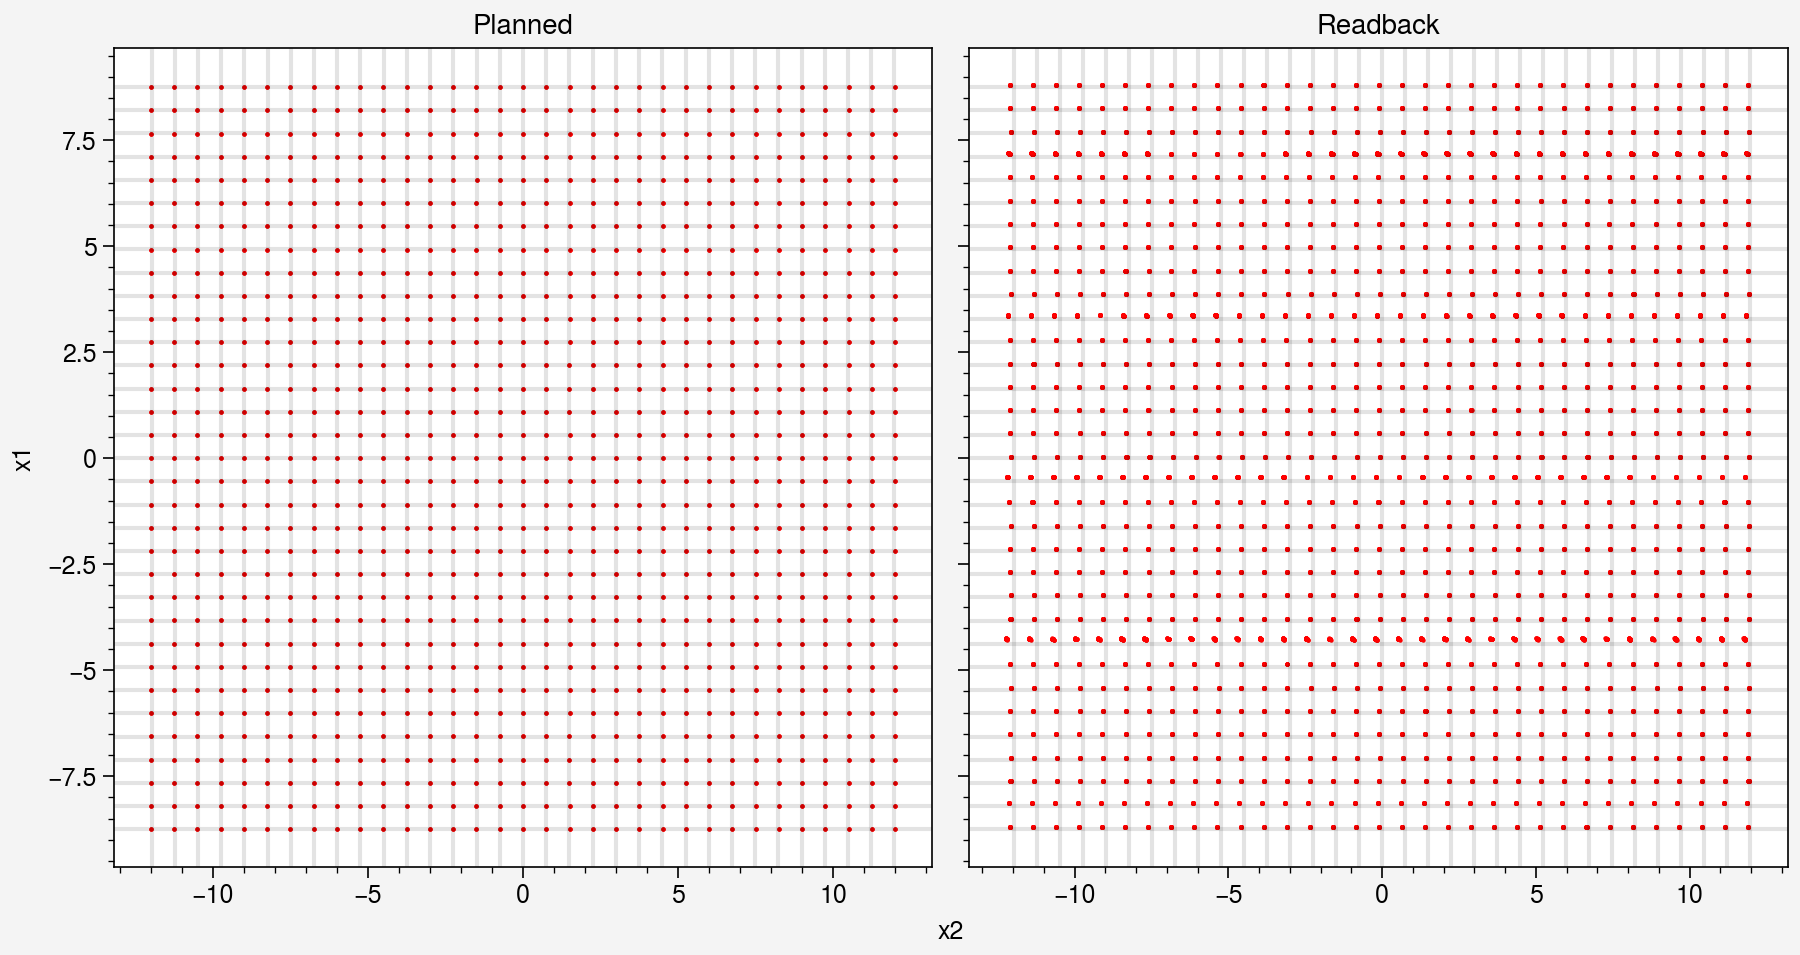

In [37]:
fig, axes = pplt.subplots(ncols=2, figwidth=9)
line_kws = dict(color='black', alpha=0.11)
for ax, title, pts in zip(axes, ['Planned', 'Readback'], [pl_points_n, points_n]):
    for gv in gvs[1]:
        ax.axvline(gv, **line_kws)
    for gv in gvs[2]:
        ax.axhline(gv, **line_kws)    
    ax.scatter(pts[:, 1], pts[:, 2], c='red', s=1)
    ax.format(title=title)
axes.format(xlabel='x2', ylabel='x1')
plt.savefig('_output/snap.png')

`POINTS2D` holds the iteration number on the x2-x1 grid. (The number of iterations is half the number of sweeps.)

In [38]:
POINTS2D = np.full((len(gvs[2]), len(gvs[1])), np.nan)
iteration, steps = 0, []
for i in range(POINTS2D.shape[0]):
    for j in range(POINTS2D.shape[1]):
        idx, = np.where((idxs[2] == i) & (idxs[1] == j))
        if len(idx) > 0:
            POINTS2D[i, j] = iteration
            steps.append(idx)
        else:
            print(f'Bin {i},{j} is empty')
        iteration += 1
POINTS2D = POINTS2D.astype(int)

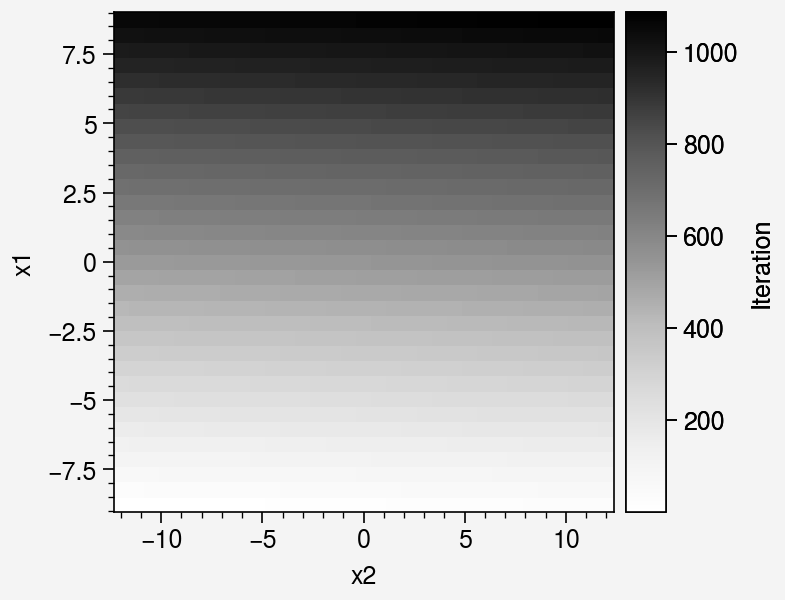

In [39]:
fig, ax = pplt.subplots()
_arr = np.zeros((POINTS2D.shape))
for i in range(POINTS2D.shape[0]):
    for j in range(POINTS2D.shape[1]):
        _arr[i, j] = -1 if np.isnan(POINTS2D[i, j]) else POINTS2D[i, j]
ax.pcolormesh(
    gvs[1], 
    gvs[2],
    np.ma.masked_less_equal(_arr, 0),  cmap='grays',
    colorbar=True, colorbar_kw=dict(label='Iteration'),
)
ax.format(ylabel='x1', xlabel='x2')
plt.savefig('_output/POINTS2D.png')

`idx_bin[i]` holds a list of all indices for iteration `i` (the ith point in the x1-x2 grid).

In [40]:
idx_bin = []
for i, step in enumerate(tqdm(steps)):
    iterations = np.unique((step / 2 + 1).astype(int))
    idx = np.hstack([np.where(data_sc[:, 'iteration'] == iteration)[0] for iteration in iterations])
    idx_bin.append(np.unique(idx))

  0%|          | 0/1089 [00:00<?, ?it/s]

### Observe one sweep

We will observe the sweep containing the largest camera integral in the scan.

In [41]:
iteration_peak, n_iterations = None, len(steps)
for iteration in range(n_iterations):
    if ipeak in idx_bin[iteration]:
        iteration_peak = iteration
        
iteration = iteration_peak
idx = idx_bin[iteration]
print(f'Peak is in iteration {iteration}')
print(f'Set iteration = {iteration}')
print(f'Set idx = idx_bin[iteration] = {idx}')

Peak is in iteration 742
Set iteration = 742
Set idx = idx_bin[iteration] = [31454 31455 31456 31457 31458 31459 31460 31461 31462 31463 31464 31465
 31466 31467 31468 31469 31470 31471 31472 31473 31474 31475 31476 31477
 31478 31479 31480 31481 31482 31483 31484 31485 31486 31487 31488 31489
 31490 31491 31492 31493 31494 31495 31496]


Observe the actuator positions and camera integral during the sweep.

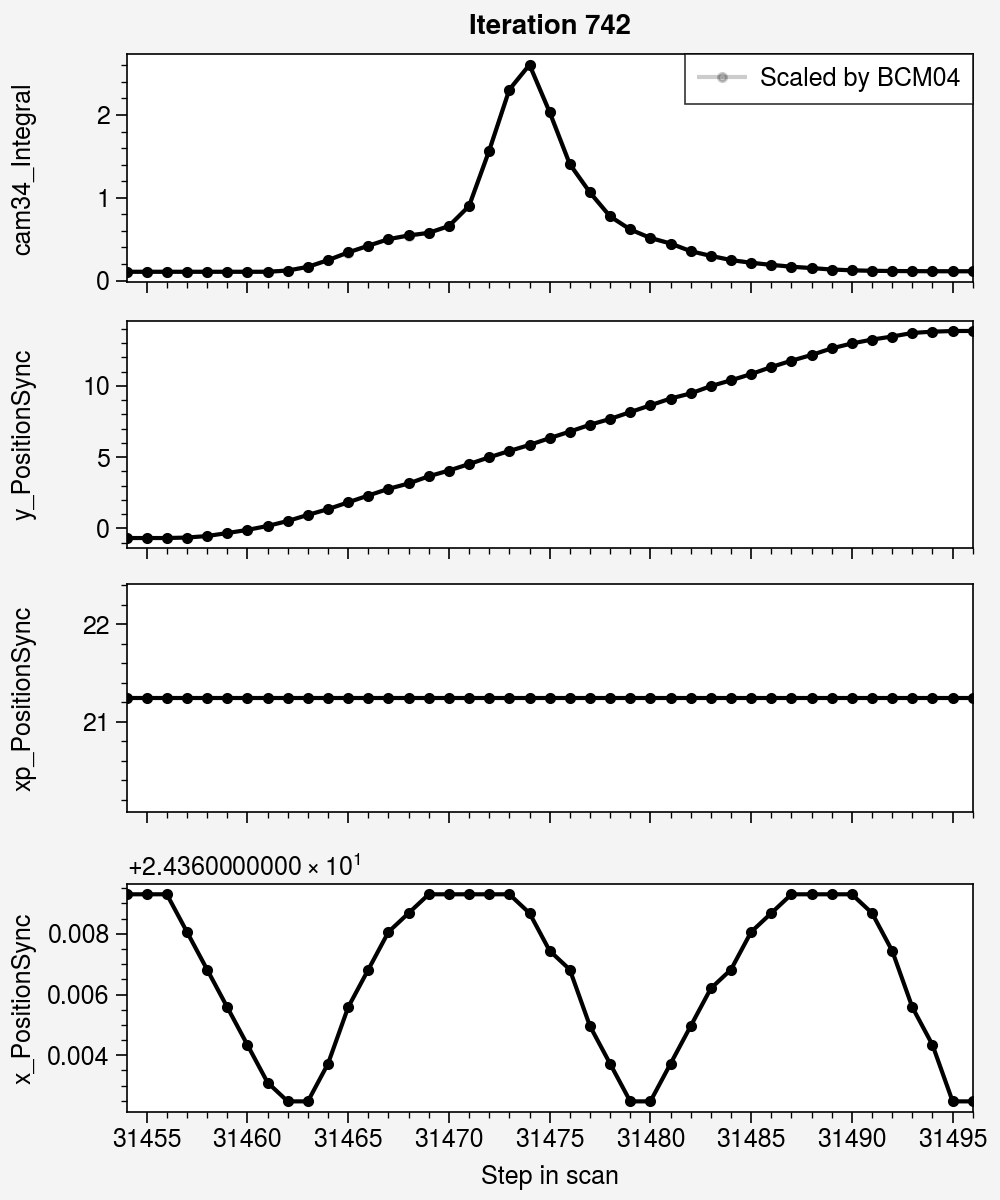

In [42]:
bcm_mean = np.mean(data_sc[:, 'bcm04'])
bcm_scale = bcm_mean / data_sc[idx, 'bcm04']

kws = dict(marker='.', color='black')
fig, axes = pplt.subplots(nrows=4, figsize=(5, 6), spany=False, aligny=True)
for _scale, alpha, label in zip([1.0, bcm_scale], [1.0, 0.2], [None, 'Scaled by BCM04']):
    axes[0].plot(idx, data_sc[idx, cam + '_Integral'] * _scale,
                 alpha=alpha, label=label, **kws)
axes[0].legend(loc='upper right')
axes[0].format(ylabel=f'{cam}_Integral')
for ax, act in zip(axes[1:], acts):
    ax.plot(idx, data_sc[idx, act], **kws)
    ax.format(ylabel=act)
axes.format(xlabel='Step in scan', suptitle=f'Iteration {iteration}')
plt.savefig(f'_output/iteration{iteration}.png')
plt.show()

Observe the image on the screen during the sweep. (The following saves a GIF.)

In [43]:
def get_image(i):
    image_shape = info['image_shape']
    return data_im[i, cam + '_Image'].reshape(image_shape)

In [44]:
ipeak_sweep = np.argmax(data_sc[idx, cam + '_Integral'])
norm_pixel_value = np.max(data_im[idx[ipeak_sweep], cam + '_Image'])
for cmap in ['viridis', 'dusk_r', 'mono_r']:
    _cmap = pplt.Colormap(cmap)
    greyscale = False

    _ims = []
    for i in tqdm(idx):
        _im = get_image(i) / norm_pixel_value
        if not greyscale:
            _im = _cmap(_im)
        _ims.append(np.uint8(_im * np.iinfo(np.uint8).max))

    gif_filename = f'_output/iteration{iteration}_{cmap}.gif'
    imageio.mimwrite(gif_filename, _ims, fps=6)

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

### Form 3D image

Each sweep/iteration — each point in the x1-x2 grid — produces a 3D image: y1-y3-x3.

In [45]:
im3d = np.array([get_image(i) for i in idx])
print(im3d.shape)

(43, 75, 63)


The image will be interpolated over the y1 axis. There is the option to apply a smoothing filter before interpolation. (I have actually found this to decrease the quality of the interpolation, but maybe that is because my images were already downscaled. This might have to do with the fact that I downscaled already? The variable `SMOOTH`, at the top of this notebook, determines whether smoothing is applied before interpolation.)

In [46]:
im3d_smooth = ndimage.median_filter(im3d, size=(3, 1, 1), mode='constant', cval=0.0) 

Compare the image with/without smoothing at the frame with the largest pixel value in the iteration.

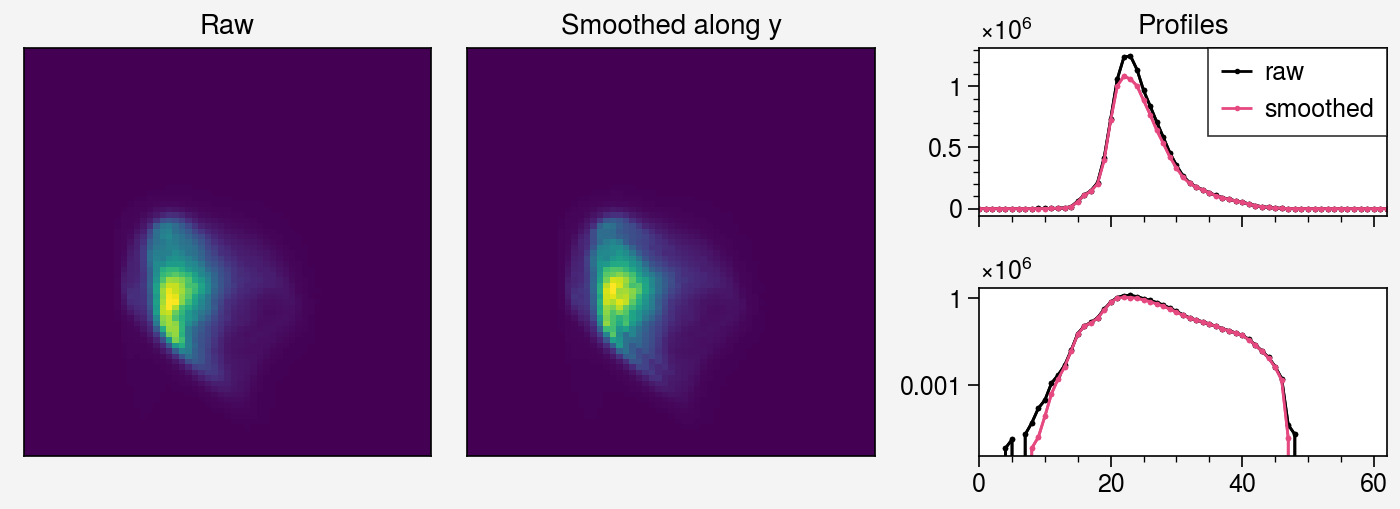

In [47]:
i, _, _ = np.unravel_index(np.argmax(im3d), im3d.shape)

fig, axes = pplt.subplots([[1, 2, 3], [1, 2, 4]], figwidth=7, sharey=False)
axes[0].pcolormesh(im3d[i, :, :])
axes[1].pcolormesh(im3d_smooth[i, :, :])
for yscale in [None, 'log']:
    for ax in axes[2:]:
        handles = []
        for color, _im3d in zip(['black', 'pink6'], [im3d, im3d_smooth]):
            handle = ax.plot(np.sum(_im3d[i, :, :], axis=0), color=color, marker='.', ms=2, lw=1)
            handles.append(handle)
axes[3].format(yscale='log')
for ax, title in zip(axes, ['Raw', 'Smoothed along y', 'Profiles']):
    ax.set_title(title)
axes[:2].format(xticks=[], yticks=[])
axes[2].legend(handles, labels=['raw', 'smoothed'], ncol=1, loc='upper right', handlelength=1.25)
plt.savefig('_output/raw_vs_smooth_proj.png')
plt.show()

Look at different x3-y3 pixels for all y1.

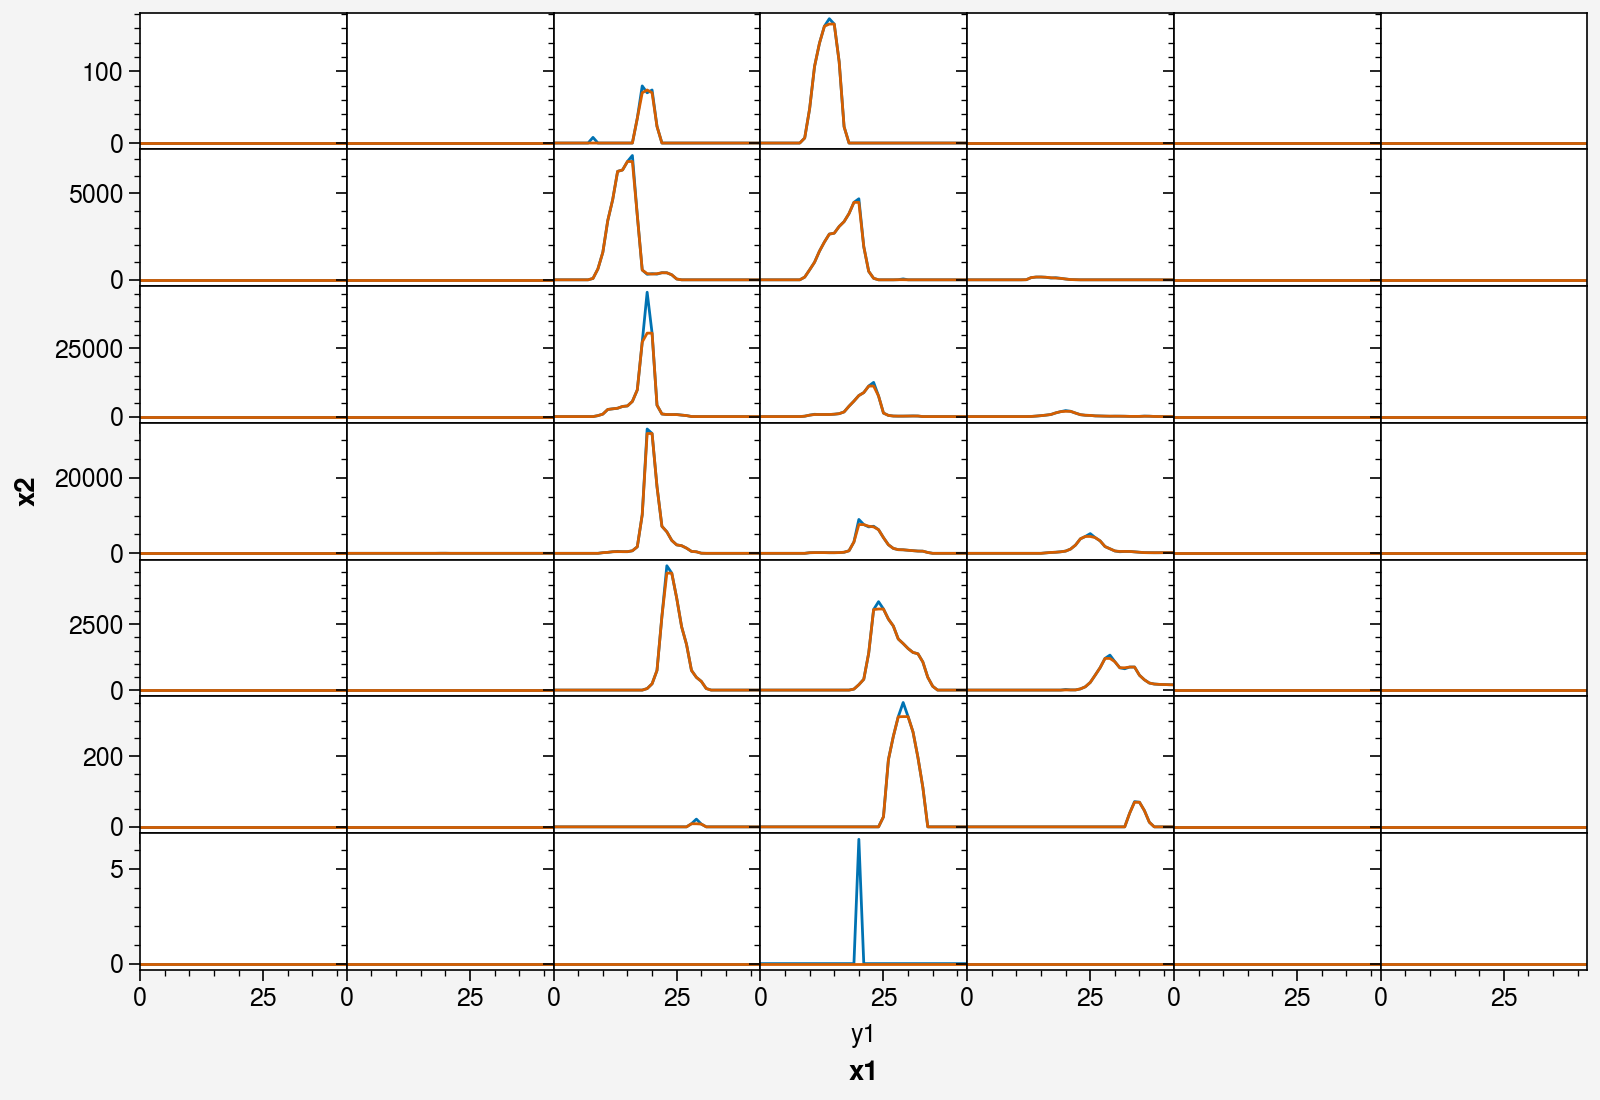

In [48]:
n = 7
ii = np.linspace(0, im3d.shape[1] - 1, n).astype(int)
jj = np.linspace(0, im3d.shape[2] - 1, n).astype(int)

fig, axes = pplt.subplots(ncols=n, nrows=n, figsize=(8.0, 5.5), space=0)
axes.format(
    xlabel='y1', 
    bottomlabels=['', '', '', 'x1', '', '', ''], 
    leftlabels=['', '', '', 'x2', '', '', ''],
)
for row, i in enumerate(ii):
    for col, j in enumerate(jj):
        ax = axes[row, col]
        kws = dict(lw=1.0)
        ax.plot(im3d[:, i, j], **kws)
        ax.plot(im3d_smooth[:, i, j], **kws)
plt.savefig('_output/y1_smoothing.png')
plt.show()

### Interpolate over y1

In [49]:
# Define the y1 grid using all points in the data set.
N_PTS_Y = variables['y1']['steps']
y1_gv = np.linspace(
    np.min(data_sc['y_PositionSync']),
    np.max(data_sc['y_PositionSync']),
    N_PTS_Y,
)

# Obtain the y1 values corresponding to the y1 axis.
y1_vals = data_sc[idx, 'y_PositionSync']

# Interpolate along the y1 axis.
interp_method = 'linear'
_im3d = im3d_smooth if SMOOTH else im3d
arr3d = ip.interp_along_axis(_im3d, y1_vals, y1_gv, axis=0, kind=interp_method)

Find the the indices of the maximum element of the 3D image. Keep in mind that if `im3d` has many more y elements than `arr3d`, the plots may not look the same. 

In [50]:
frame1, row, col = utils.max_indices(im3d)
frame2, _, _ = utils.max_indices(arr3d)

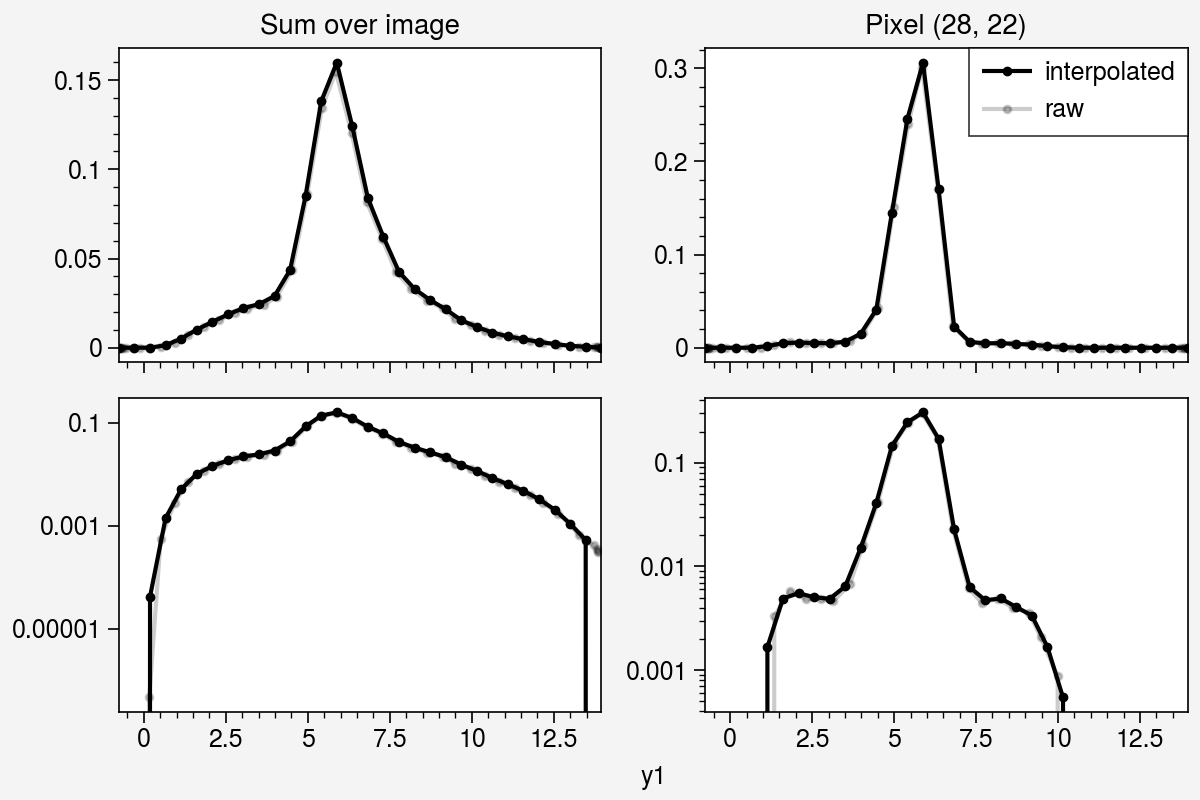

In [51]:
fig, axes = pplt.subplots(ncols=2, nrows=2, sharey=False, figsize=(6, 4))
for x, arr, alpha, label in zip([y1_gv, y1_vals], [arr3d, im3d], [1.0, 0.2], ['interpolated', 'raw']):
    for j in range(2):
        y = utils.project(arr, 0) if j == 0 else arr[:, row, col]
        y = y / np.sum(y)
        for i, ax in enumerate(axes[:, j]):
            ax.plot(x, y, color='black', label=label, marker='.', alpha=alpha, ms=5)
axes[0, 1].legend(loc='upper right', ncol=1,)
axes[1, :].format(yscale='log', xlabel='y1')
for ax, title in zip(axes[0, :], ['Sum over image', f'Pixel ({row}, {col})']):
    ax.format(title=title)
plt.savefig('_output/peak_frame_interp_compare.png')

Plot the frame with the maximum pixel in either array.

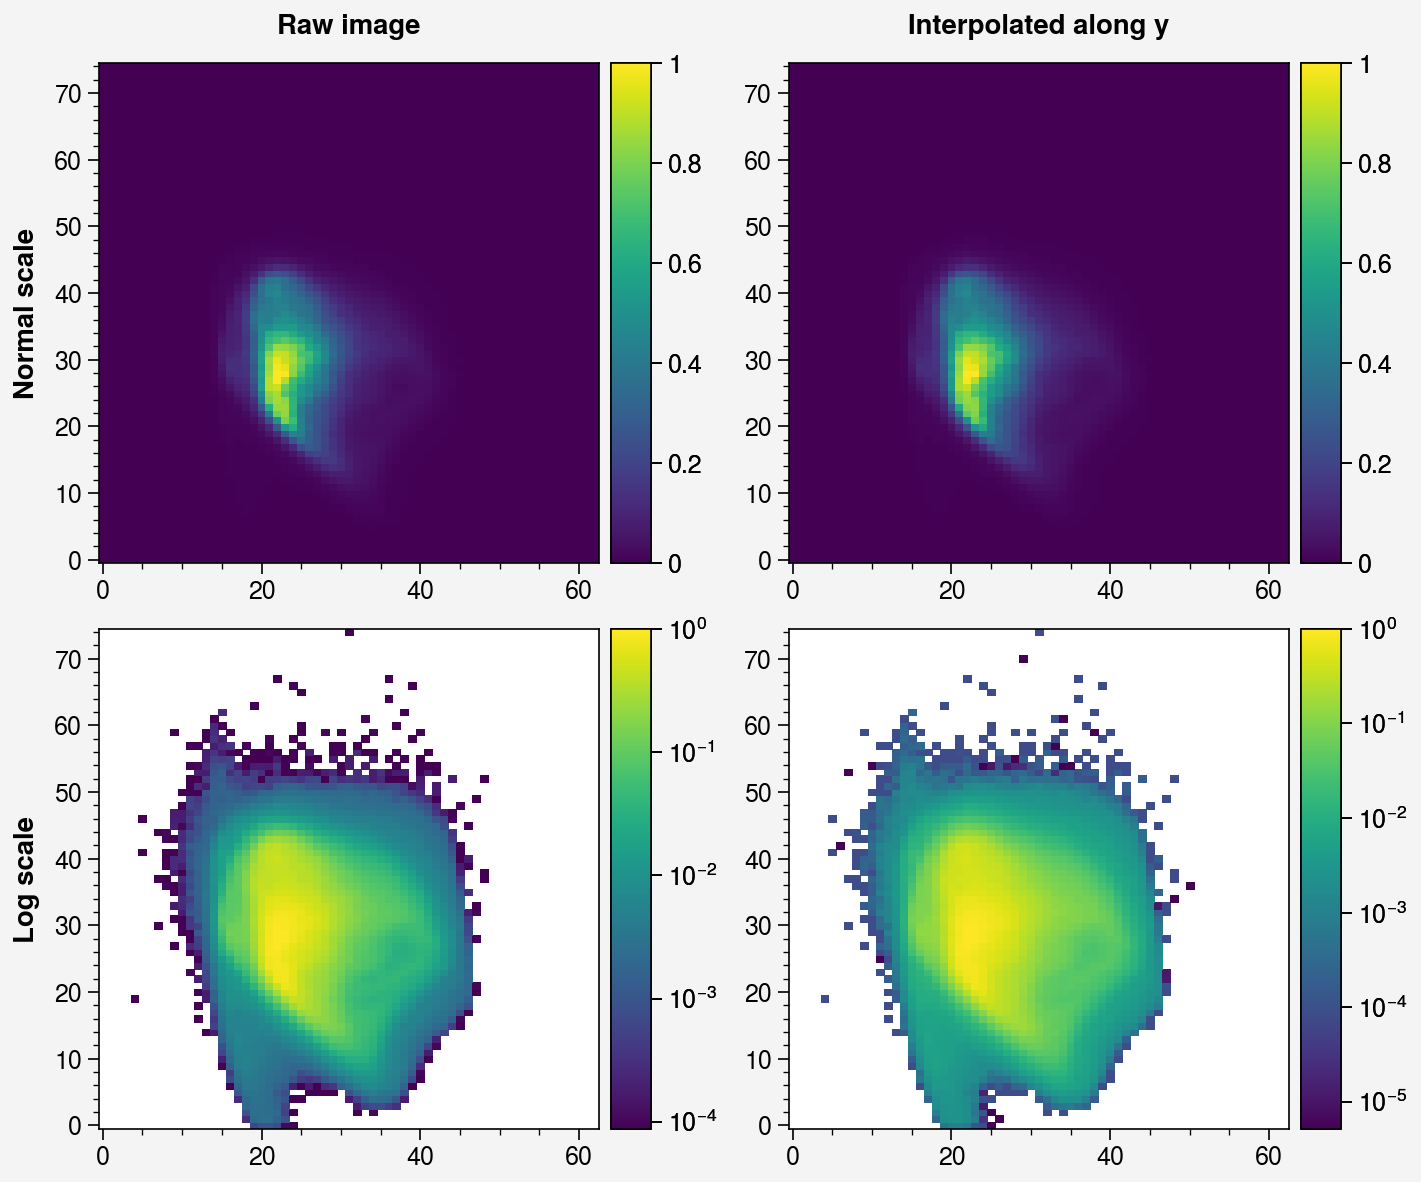

In [52]:
fig, axes = pplt.subplots(ncols=2, nrows=2, figwidth=None, sharex=False, sharey=False)
for j, _im in enumerate([im3d[frame1, :, :], arr3d[frame2, :, :]]):
    for i, norm in enumerate([None, 'log']):
        mplt.plot_image(_im.T / np.max(_im), ax=axes[i, j], norm=norm, colorbar=True)
axes.format(
    leftlabels=['Normal scale', 'Log scale'],
    toplabels=['Raw image', 'Interpolated along y']
)
plt.savefig('_output/interp_image_compare.png')

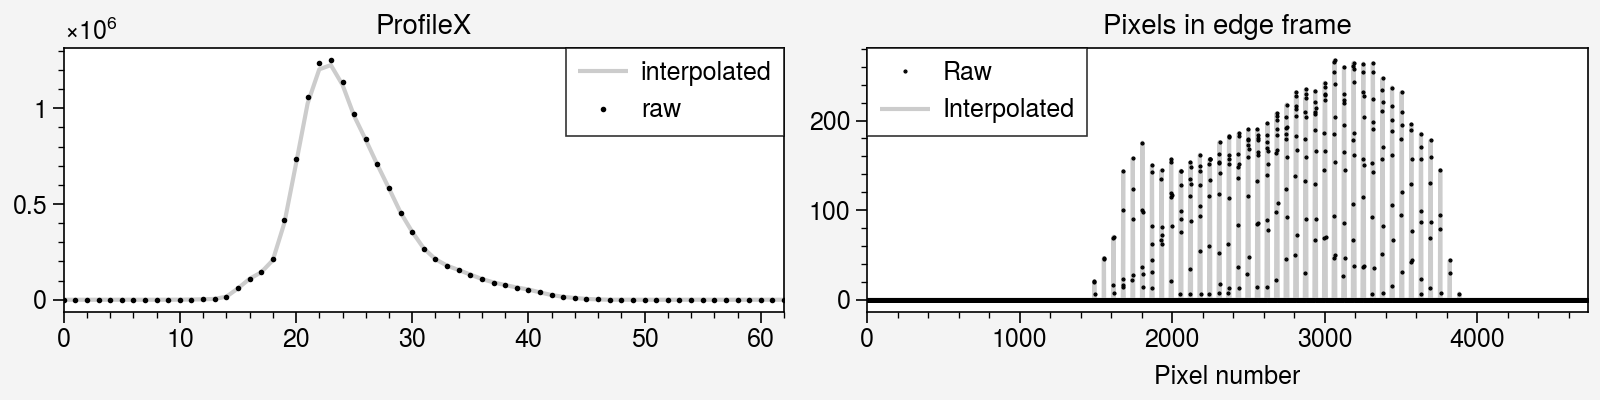

In [53]:
fig, axes = pplt.subplots(ncols=2, sharey=False, spanx=False, figsize=(8, 2))
axes[0].plot(np.sum(arr3d[frame2, :, :], axis=0), color='black', alpha=0.2, label='interpolated')
axes[0].plot(np.sum(im3d[frame1, :, :], axis=0), marker='.', ms=2, lw=0, color='black', label='raw')
axes[0].legend(ncol=1)
axes[0].format(yscale=None, title='ProfileX')
axes[1].plot(arr3d[-2, :, :].ravel(), marker='.', lw=0, color='black', ms=1, label='Raw')
axes[1].plot(arr3d[-2, :, :].ravel(), color='black', alpha=0.2, label='Interpolated')
axes[1].legend(loc='upper left', ncols=1)
axes[1].format(title='Pixels in edge frame', xlabel='Pixel number')
plt.savefig('_output/interp_px.png')

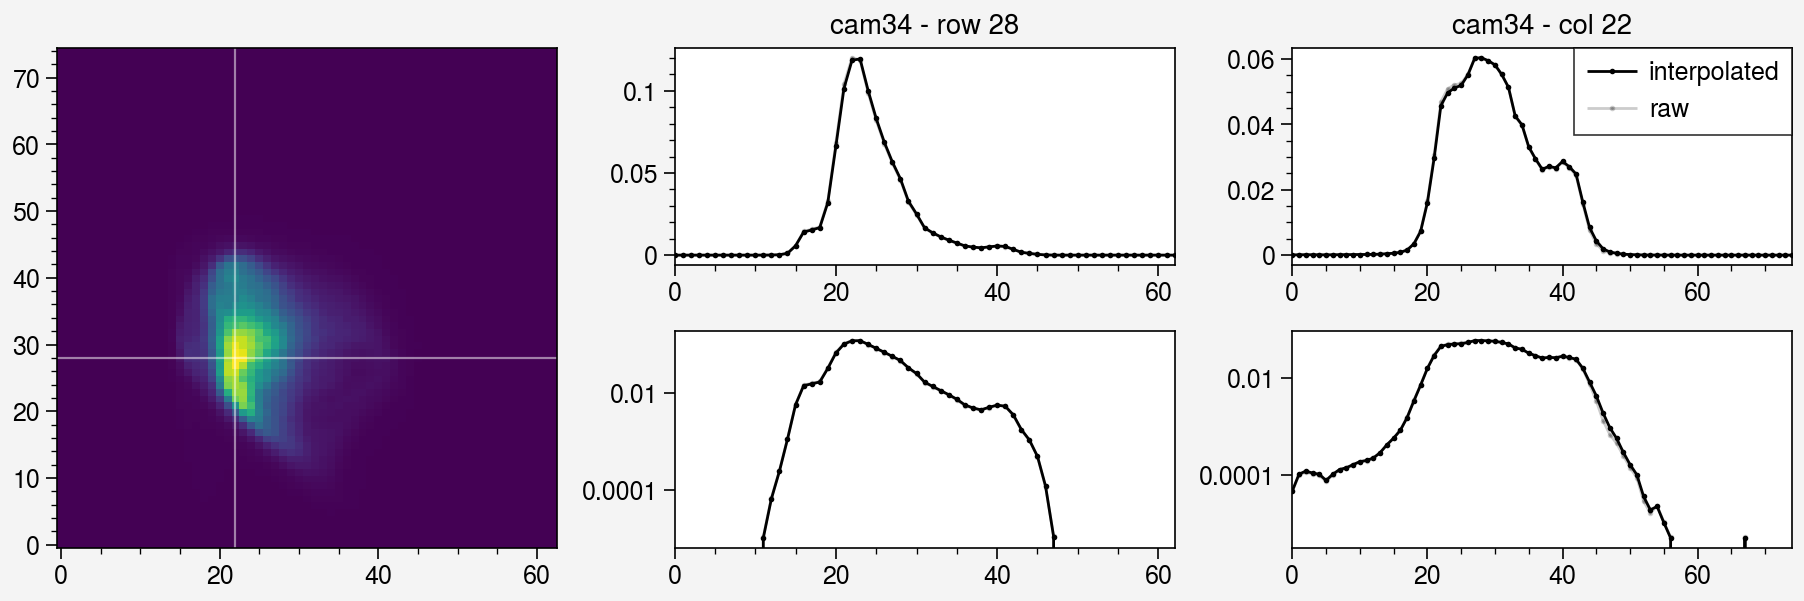

In [54]:
fig, axes = pplt.subplots([[1, 2, 3], [1, 4, 5]], sharey=False, sharex=False)
axes[0].pcolormesh(im3d[frame1, :, :])
kws = dict(color='white', lw=0.785, alpha=0.5)
axes[0].axvline(col, **kws)
axes[0].axhline(row, **kws)
kws = dict(marker='.', color='black', ms=2.0, lw=1.0)
for im, label in zip([arr3d[frame2], im3d[frame1]], ['interpolated', 'raw']):
    if label == 'raw':
        kws['alpha'] = 0.2
    elif label == 'interpolated':
        kws['alpha'] = 1.0
    for ax in axes[:, 1]:
        ax.plot(im[row, :] / np.sum(im[row, :]), label=label, **kws)
    for ax in axes[:, 2]:
        ax.plot(im[:, col] / np.sum(im[:, col]), label=label, **kws)
axes[2].legend(ncols=1, loc='upper right')
axes[1].set_title(f'{cam} - row {row}')
axes[2].set_title(f'{cam} - col {col}')
axes[1, 1:].format(yscale='log')
plt.savefig('_output/interp_peak_slice.png')
plt.show()

Now try comparing all x3-y3 projections of 3D image — interpolated vs. not.

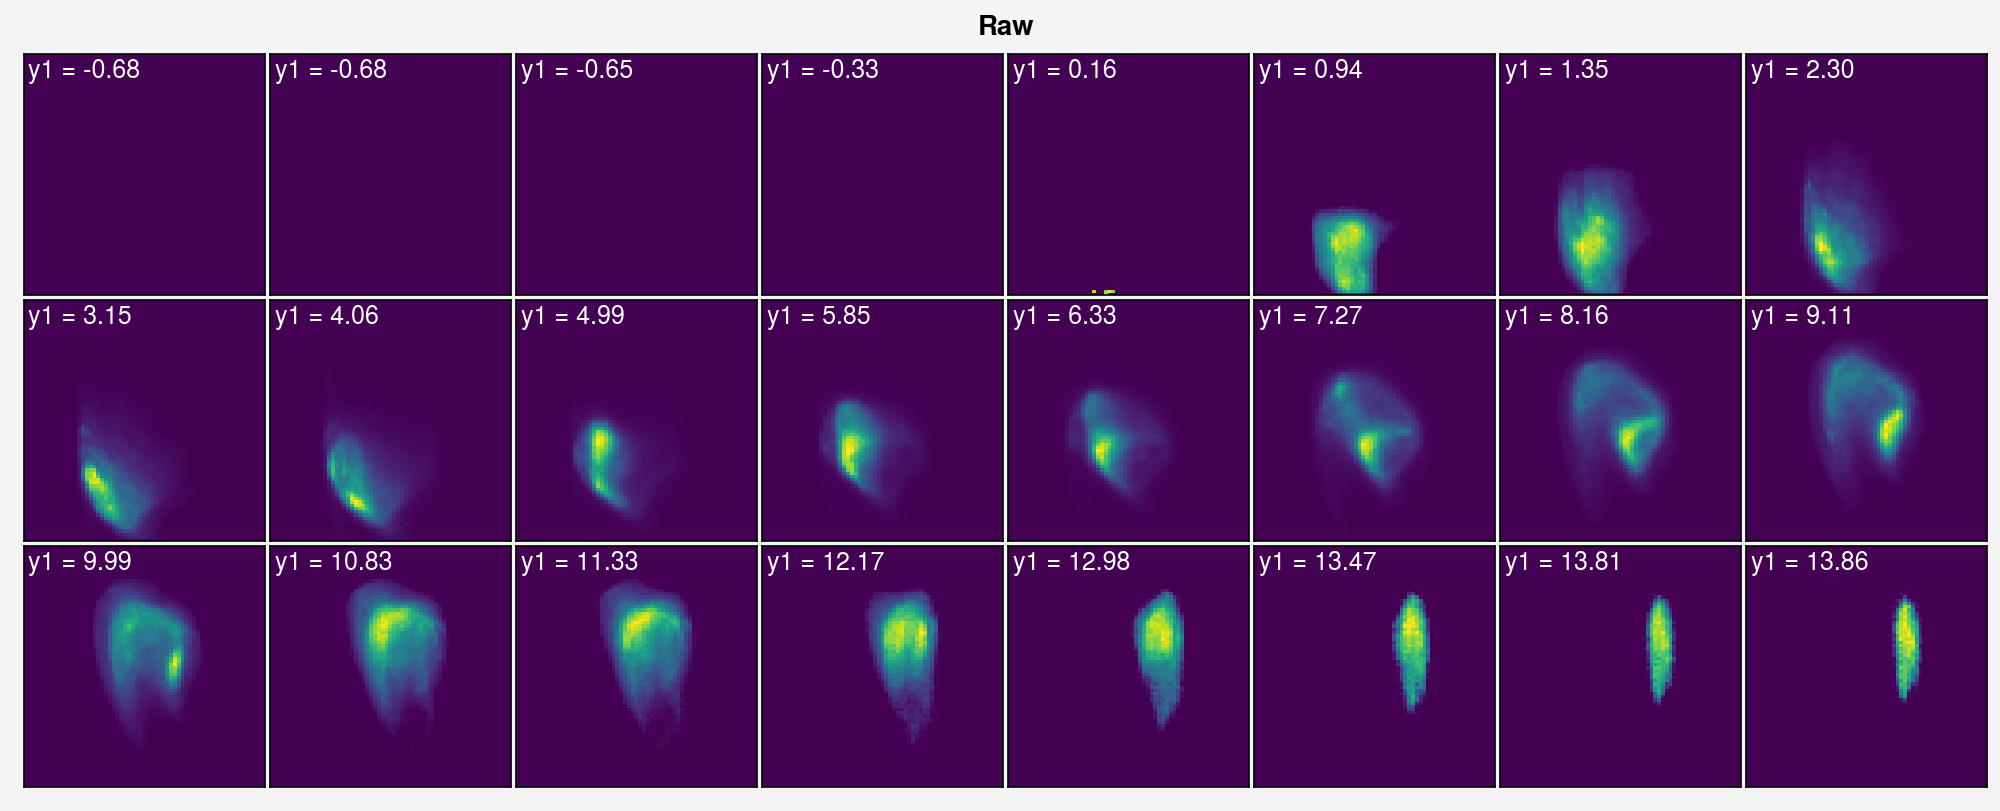

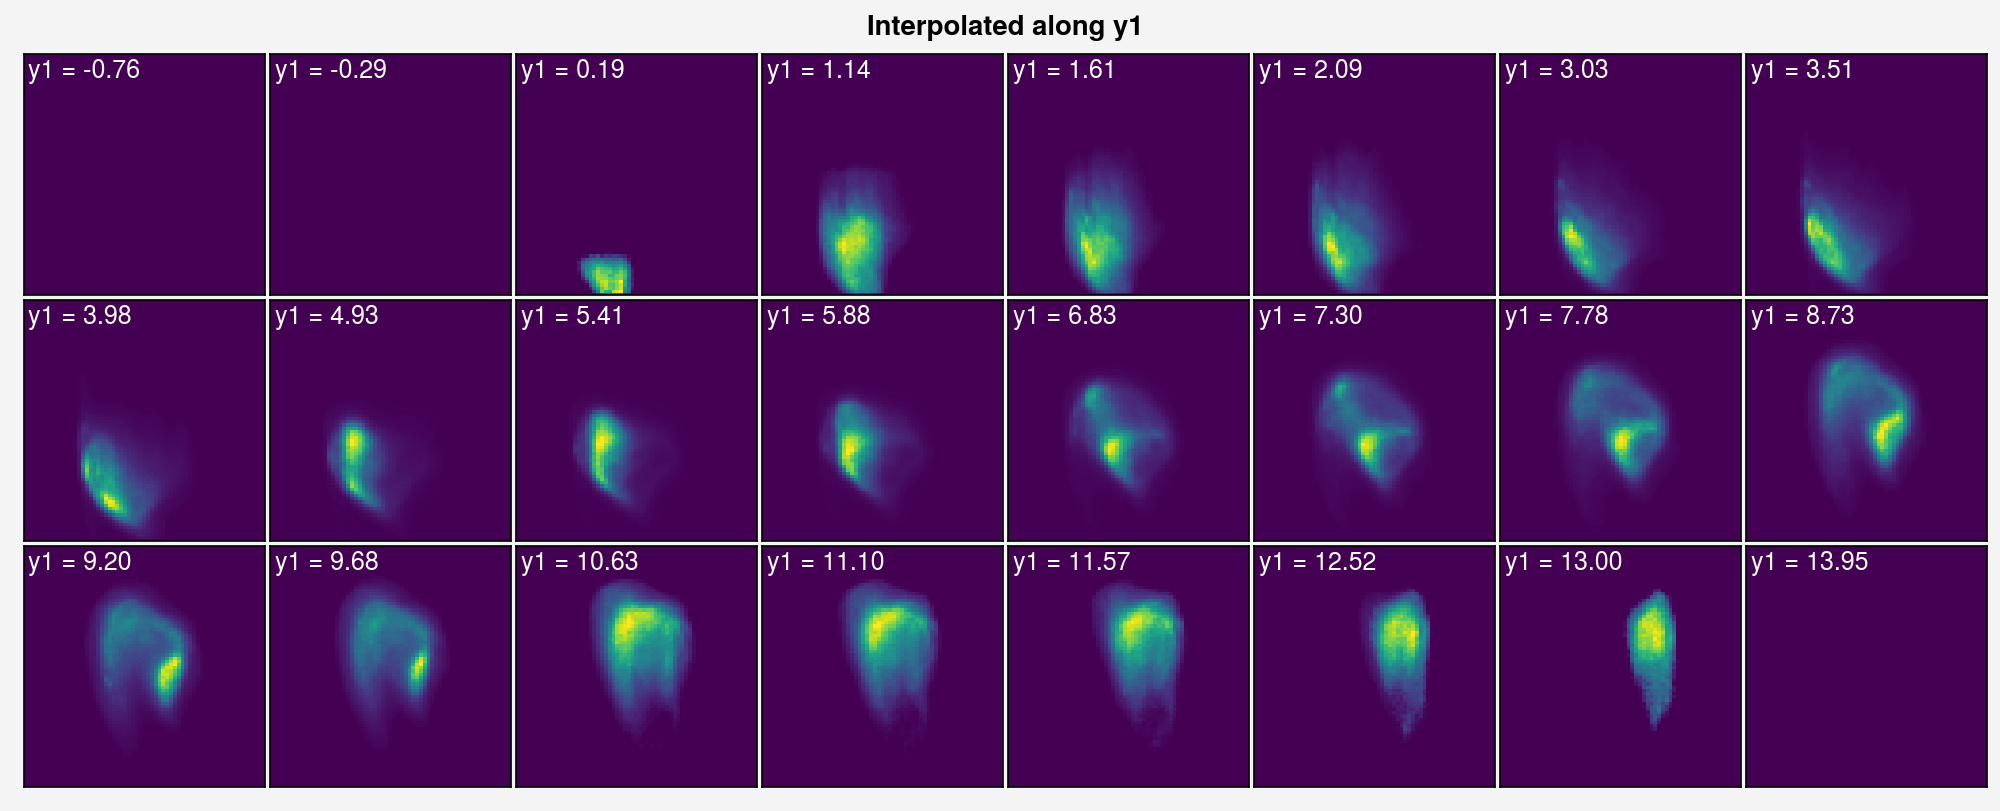

In [55]:
ncols = 8
nplots = 3 * ncols
for j, (title, _arr) in enumerate(zip(['Raw', 'Interpolated along y1'], [im3d, arr3d])):
    ind = np.linspace(0, _arr.shape[0] - 1, 24).astype(int)
    nrows = np.ceil(len(ind) / float(ncols)).astype(int)
    fig, axes = pplt.subplots(ncols=ncols, nrows=nrows, figwidth=10.0, space=0.2)
    axes.format(xticks=[], yticks=[])
    _y1 = [y1_vals, y1_gv][j]
    for ax, i in zip(axes, ind):
        mplt.plot_image(_arr[i].T, ax=ax)
        ax.annotate(f'y1 = {_y1[i]:.2f}', xy=(0.02, 0.98), xycoords='axes fraction',
                    color='white', verticalalignment='top')
    for i in range(nrows * ncols - len(ind)):
        axes[~i].axis('off')
    axes.format(suptitle=title)
    plt.savefig(f"_output/iteration{iteration}_{['raw','y1interp'][j]}.png")
    plt.show()

## View projections and slices of interpolated 3D image 

### Projections

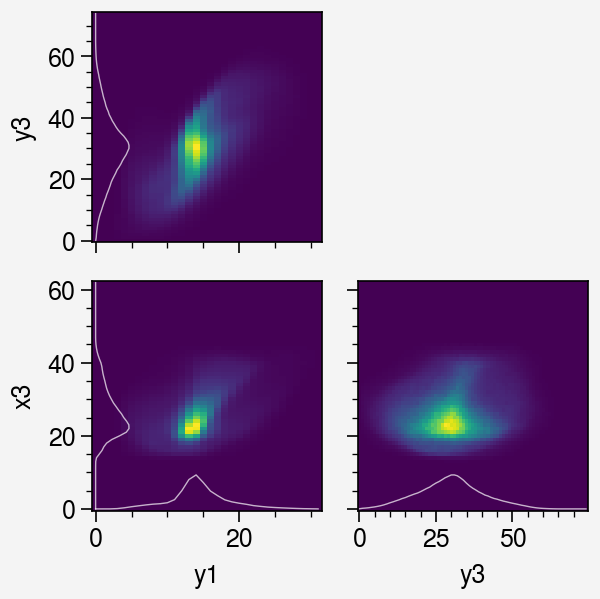

In [56]:
dims = ['y1', 'y3', 'x3']
axes = mplt.corner(arr3d, diag_kind=None, labels=dims, prof='edges',
                   prof_kws=dict(lw=0.5, alpha=0.7))
plt.savefig('_output/peak_interp_proj_corner.png')

### Slices

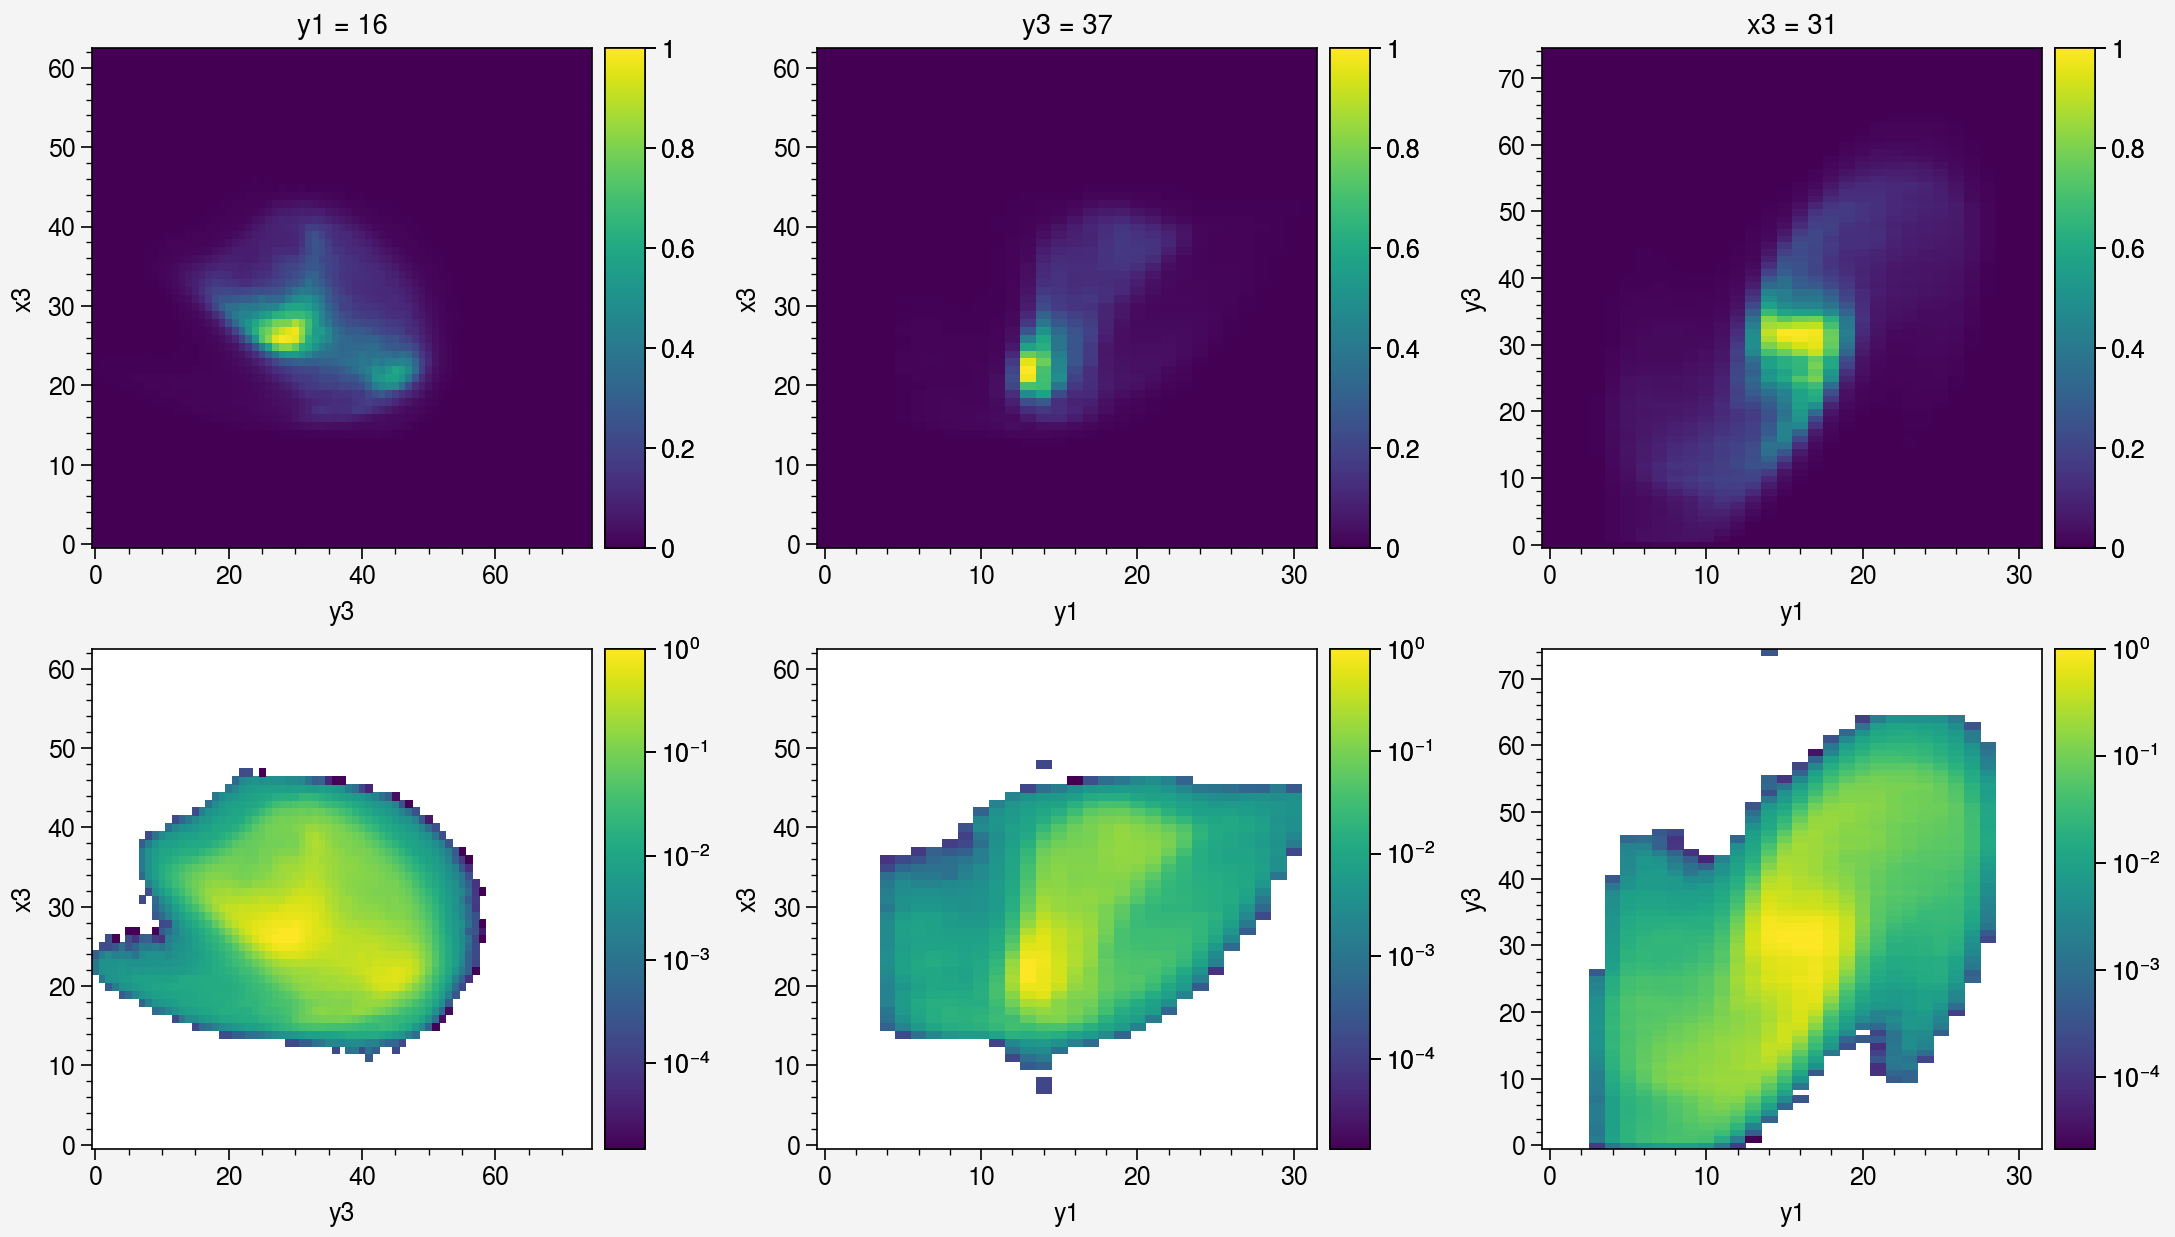

In [57]:
ind_slice = [int(s / 2) for s in arr3d.shape]

plot_kws = dict(discrete=False, colorbar=True)
fig, axes = pplt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, spany=False, spanx=False, )
for j in range(3):
    idx = utils.make_slice(3, j, ind_slice[j])
    _im = arr3d[idx]
    _im = _im / np.max(_im)
    for ax, norm in zip(axes[:, j], [None, 'log']):
        mplt.plot_image(_im, ax=ax, norm=norm, **plot_kws)
    axes[0, j].format(title=f'{dims[j]} = {ind_slice[j]}')
axes[:, 0].format(xlabel='y3', ylabel='x3')
axes[:, 1].format(xlabel='y1', ylabel='x3')
axes[:, 2].format(xlabel='y1', ylabel='y3')
plt.savefig('_output/peak_interp_slice.png')
plt.show()

In [58]:
mplt.interactive_proj2d(arr3d / np.max(arr3d), dims=['x1', 'y3', 'x3'], 
                        default_ind=(2, 1), slider_type='int')

interactive(children=(Dropdown(description='cmap', options=('viridis', 'dusk_r', 'mono_r', 'plasma'), value='v…

## Save 3D grid coordinates

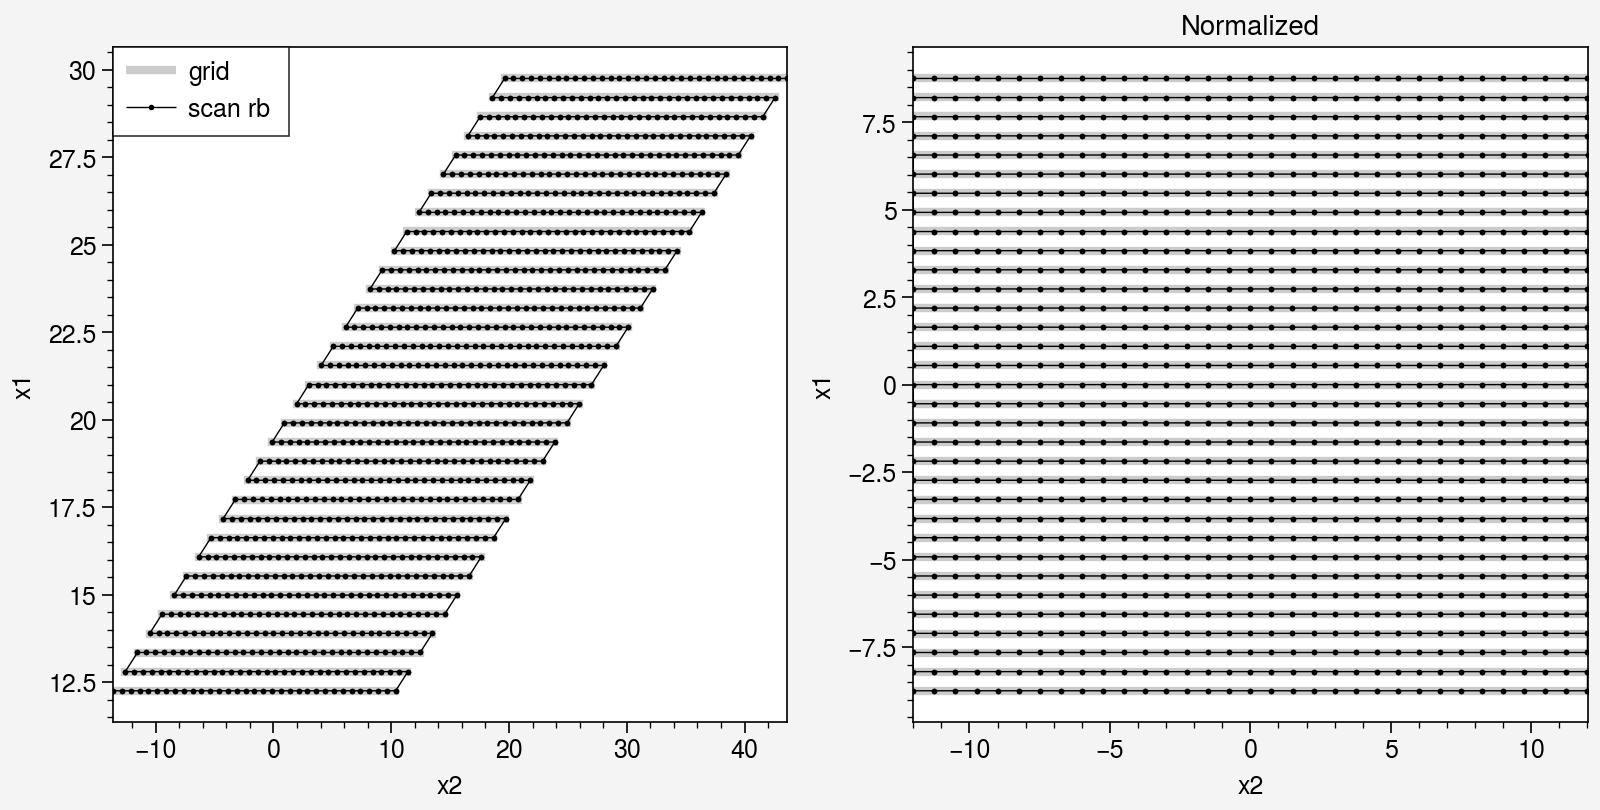

In [59]:
GV_X1_n, GV_X2_n = np.meshgrid(gvs[2], gvs[1], indexing='ij')
x2_x1_n = np.vstack([GV_X2_n.ravel(), GV_X1_n.ravel()]).T
x2_x1 = utils.apply(M[1:, 1:], x2_x1_n) + center[1:]
GV_X2 = x2_x1[:, 0].reshape(GV_X2_n.shape)
GV_X1 = x2_x1[:, 1].reshape(GV_X1_n.shape)

fig, axes = pplt.subplots(ncols=2, figwidth=8, sharey=False, sharex=False)
for ax, (grid1, grid2), pts in zip(axes, [(GV_X2, GV_X1), (GV_X2_n, GV_X1_n)], [pl_points, pl_points_n]):
    _h1 = ax.plot(grid1.T, grid2.T, color='black', alpha=0.2, lw=3)
    _h2 = ax.plot(pts[:, 1], pts[:, 2], color='black', marker='.', ms=2, lw=0.5)
axes.format(xlabel='x2', ylabel='x1')
axes[0].legend([_h1, _h2], labels=['grid', 'scan rb'], loc='upper left')
axes[1].format(title='Normalized')
plt.savefig('_output/x1-x2-grid.png')

Obtain 3D grid coordinates.

In [60]:
X1 = np.repeat(GV_X1[:, :, np.newaxis], N_PTS_Y, axis=2)
X2 = np.repeat(GV_X2[:, :, np.newaxis], N_PTS_Y, axis=2)
Y1 = np.zeros(X1.shape)
for i in range(Y1.shape[0]):
    for j in range(Y1.shape[1]):
        Y1[i, j, :] = y1_gv

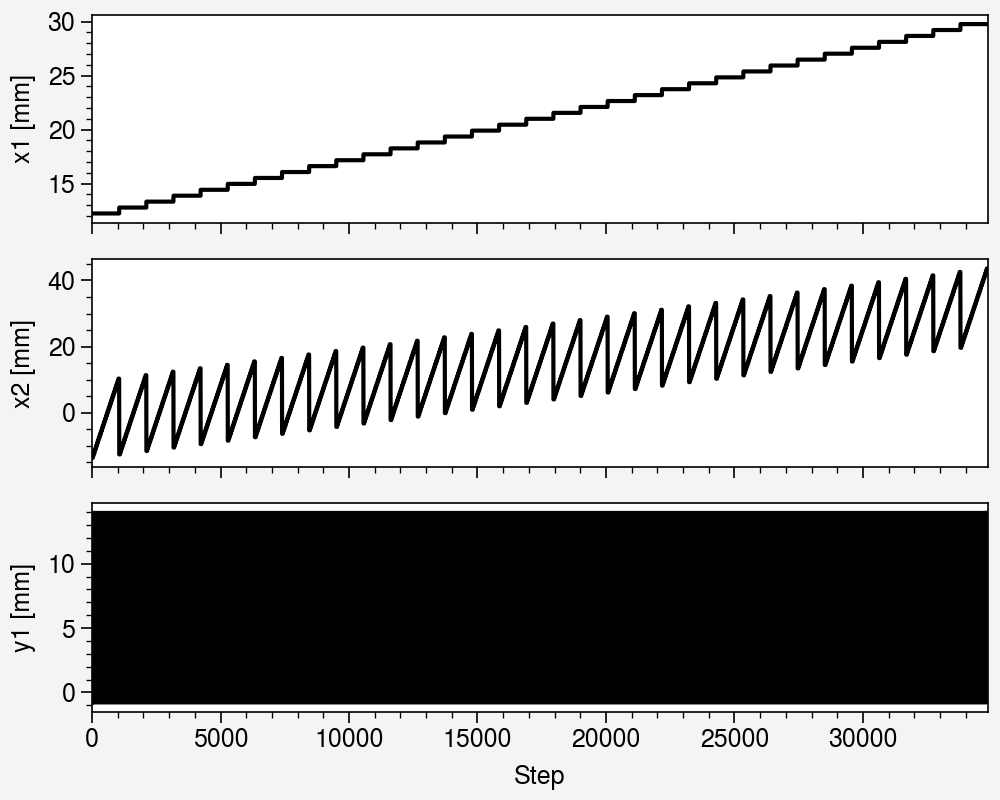

In [61]:
fig, axes = pplt.subplots(nrows=3, figsize=(5, 4), spany=False, aligny=True)
for ax, G, ylabel in zip(axes, [X1, X2, Y1], ["x1 [mm]", "x2 [mm]", "y1 [mm]"]):
    ax.plot(G.ravel(), color='black')
    ax.format(ylabel=ylabel)
axes.format(xlabel='Step')
plt.savefig('_output/acts_black.png')

In [62]:
coord_3d = np.stack([X1, X2, Y1], axis=0)
print(f'coord_3d.shape = {coord_3d.shape}')

coord_3d.shape = (3, 33, 33, 32)


In [63]:
savefilename = f'_output/coordinates3d_raw_{filename}.npy'
np.save(savefilename, coord_3d)

## Save 5D array as memory map 

In [64]:
shape = [len(gvs[2]), len(gvs[1])] + list(arr3d.shape)  # [x1, x2, y1, y3, x3]
shape = tuple(shape)
info['rawgrid_shape'] = shape
print('shape:', shape)

shape: (33, 33, 32, 75, 63)


In [65]:
im_dtype = get_image(0).dtype
info['im_dtype'] = im_dtype
print('image dtype:', im_dtype)

image dtype: float64


In [66]:
utils.save_pickle('_output/info.pkl', info)
file = open('_output/info.txt', 'w')
for key, value in info.items():
    file.write(f'{key}: {value}\n')
file.close()

In [67]:
savefilename = f'_output/f_raw_{filename}.mmp'
f_raw = np.memmap(savefilename, shape=shape, dtype=im_dtype, mode='w+') 
for i in trange(POINTS2D.shape[0]):
    for j in range(POINTS2D.shape[1]):
        try:
            iteration = POINTS2D[i, j]
            idx = idx_bin[iteration]
            im3d = np.array([get_image(k) for k in idx])
            if SMOOTH:
                im3d = ndimage.median_filter(im3d, size=(3, 1, 1), mode='constant', cval=0.0) 
            y1_vals = data_sc[idx, 'y_PositionSync']
            f_raw[i, j, :, :, :] = ip.interp_along_axis(im3d, y1_vals, y1_gv, axis=0, kind=interp_method)
        except IndexError:
            print(f'No points in grid bin ({i}, {j})')
            f_raw[i, j, :, :, :] = 0
del f_raw

  0%|          | 0/33 [00:00<?, ?it/s]